### Team Classy Pie
---
# ■ Shelter Animal Outcomes, 보호소 동물들의 결과 예측하기

## Contents
> ### 1. Introduction -  프로젝트 소개
> ### 2. Datasets - 데이터 소개
> ### 3. Evaluation - 평가기준
> ### 4. EDA - 탐색적 자료 분석
> ### 5. Feature Engineering - 데이터 전처리
> ### 6. Modeling - Cross Validation - 모델링 및 검증 
> ### 7. To improve performance - 성능향상을 위한 추가사항
> ### 8. Submit Kaggle and get Score - 캐글 제출 및 결과확인
> ### 9. Conclusion - 결론


---

# 1. Introduction

    
> ### 1-1. 미국의 애완동물 현황
> - 미국 가정의 약 44%가 애완 동물을 기른다.
> - 매년 미국에서 760만 마리가 아래의 이유로 보호소에 오게 된다.    
    - 주인이 원치 않음
    - 길을 잃음
    - 학대를 당함
>
>
> - 보호소에 오는 동물들이 주인을 찾아가기도 하지만 **매년 270만 마리, 약 35%는 안락사**를 당한다.
    

> ### 1-2. 프로젝트 목표
> - 미국 텍사스의 **Austin Animal Center**는 모든 동물들에게 집을 찾아주는 것을 목표
> - 동물들의 특성 데이터를 제공해서 각 동물들의 결과를 예측
> - 입양이 덜 되는 동물들에게 에너지를 쏟아 입양률을 높이기 위한 목적

---
# 2. Datasets

- 총 3개의 파일 (Train, Test, Submission)

- 2013.10 ~ 2016.03 기간동안 보호소에 온 강아지, 고양이의 정보
    

In [1]:
import pandas as pd

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### 2-1. Train Data

In [3]:
# train 데이터 사이즈
print(train.shape)

(26729, 10)


In [4]:
train.tail(3)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
26726,A698128,Zeus,2015-03-09 13:33:00,Adoption,NaN,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan
26727,A677478,NaN,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black
26728,A706629,NaN,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White


In [5]:
train.isnull().sum()

AnimalID              0
Name               7691
DateTime              0
OutcomeType           0
OutcomeSubtype    13612
AnimalType            0
SexuponOutcome        1
AgeuponOutcome       18
Breed                 0
Color                 0
dtype: int64

In [6]:
train.describe().T

,count,unique,top,freq
AnimalID,26729,26729,A693147,1
Name,19038,6374,Max,136
DateTime,26729,22918,2015-08-11 00:00:00,19
OutcomeType,26729,5,Adoption,10769
OutcomeSubtype,13117,16,Partner,7816
AnimalType,26729,2,Dog,15595
SexuponOutcome,26728,5,Neutered Male,9779
AgeuponOutcome,26711,44,1 year,3969
Breed,26729,1380,Domestic Shorthair Mix,8810
Color,26729,366,Black/White,2824


### 2-2. Test Data

In [7]:
# test 데이터 사이즈
print(test.shape)

(11456, 8)


In [8]:
test.tail(3)

,ID,Name,DateTime,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color
11453,11454,NaN,2014-09-29 09:00:00,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico
11454,11455,Rambo,2015-09-05 17:16:00,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan
11455,11456,Gusto,2014-07-12 18:40:00,Dog,Intact Male,4 years,Labrador Retriever,Cream


In [9]:
test.isnull().sum()

ID                   0
Name              3225
DateTime             0
AnimalType           0
SexuponOutcome       0
AgeuponOutcome       6
Breed                0
Color                0
dtype: int64

### 2-3. Submission
- sample_submission.csv : a sample submission file in the correct format
    - 동물들이 떠날때 클래스별 예측 확률

--- 
# 3. Evalutaion

    Submissions are evaluated using the multi-class logarithmic loss.
    
    where N is the number of animals in the test set, M is the number of outcomes
    log is the natural logarithm
    yij is 1 if observation i is in outcome j and 0 otherwise
    pij is the predicted probability that observation i belongs to outcome j.
    


$ \Large -\frac{1}{N} \sum \sum y_{ij}log(p_{ij}) $

---
# 4. EDA & Feature Engineering

## 4-1. Setup

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
import sklearn as sk

%matplotlib inline
%config InlineBackend.figure_formats = {'png','retina'}

import matplotlib as mpl
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
sns.set()
sns.set_style("whitegrid")
sns.set_color_codes()

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 1000)

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [4]:
Breed_dev = pd.DataFrame(columns=["Breed_extra","Breed_Life","Breed_Size",
                                  "Breed_Acti","Breed_Smrt","Breed_Frdy","Breed_Agsv"])
Breed_dev["Breed_extra"] = ['Abyssinian','Angora','Affenpinscher', 'AfghanHound', 'AiredaleTerrier',
       'Akita', 'AlaskanHusky', 'AlaskanMalamute',
       'AmericanBulldog', 'AmericanEskimo', 'AmericanFoxhound',
       'AmericanPitBullTerrier', 'AmericanStaffordshireTerrier',
       'AnatolShepherd', 'AustralianCattleDog',
       'AustralianKelpie', 'AustralianShepherd', 'AustralianTerrier',
       'Balinese', 'Basenji', 'BassetHound', 'Beagle', 'BeardedCollie',
       'Beauceron', 'BedlingtonTerr', 'BelgianMalinois', 'BelgianSheepdog',
       'BelgianTervuren', 'Bengal', 'BerneseMountainDog', 'BichonFrise',
       'BlackMouthCur', 'Bloodhound', 'BlueLacy', 'BluetickHound',
       'Boerboel', 'Bombay', 'BorderCollie', 'BorderTerrier', 'Borzoi',
       'BostonTerrier', 'Boxer', 'BoykinSpan', 'Brittany',         
       'BrussGriffon', 'BullTerrier', 'BullTerrierMiniature', 'Bulldog',
       'Bullmastiff', 'Burmese', 'CairnTerrier', 'CanaanDog', 'CaneCorso',
       'CardiganWelshCorgi', 'CarolinaDog', 'Catahoula', 'CavalierSpan',     
       'ChesaBayRetr', 'Chihuahua', 'ChineseCrested', 'ChineseSharpei',    
       'ChowChow', 'CockerSpaniel', 'CollieRough', 'CollieSmooth',
       'CornishRex', 'Cymric', 'Dachshund', 'DachshundWirehair',
       'Dalmatian', 'DevonRex', 'DobermanPinsch', 'DogoArgentino', 'DogueDeBordeaux',
       'DutchShepherd', 'EnglishBulldog', 'EnglishCockerSpaniel',
       'EnglishCoonhound', 'EnglishFoxhound', 'EnglishPointer',
       'EnglishSetter', 'EnglishShepherd', 'EnglishSpringerSpaniel',
       'Entlebucher', 'Exotic', 'Feist', 'FieldSpaniel', 'FinnishSpitz',
       'FlatCoatRetriever', 'FrenchBulldog', 'GermanPinscher',
       'GermanPointer', 'GermanShepherd', 'GermanWirehairedPointer',
       'GlenOfImaal', 'GoldenRetriever', 'GreatDane', 'GreatPyrenees',
       'GreaterSwissMountainDog', 'Greyhound', 'Harrier', 'HavanaBrown',
       'Havanese', 'Himalayan', 'Hovawart', 'IbizanHound', 'IrishSetter',
       'IrishTerrier', 'IrishWolfhound', 'ItalianGreyhound',
       'JackRussellTerrier', 'JapaneseBobtail', 'JapaneseChin', 'Javanese',
       'Jindo', 'Keeshond', 'Kuvasz', 'LabradorRetriever', 'Landseer',
       'Leonberger', 'LhasaApso', 'Lowchen', 'MaineCoon', 'Maltese',
       'ManchesterTerrier', 'Manx', 'Mastiff', 'MexicanHairless',
       'MiniaturePinscher', 'MiniaturePoodle', 'MiniatureSchnauzer',
       'Munchkin', 'NeapolitanMastiff', 'Newfoundland', 'NorfolkTerrier',
       'NorwegianElkhound', 'NorwegianForestCat', 'NorwichTerrier',
       'NovaScotiaDuckTollingRetriever', 'Ocicat', 'OldEnglishBulldog',
       'OldEnglishSheepdog', 'Otterhound', 'Papillon',
       'ParsonRussellTerrier', 'PatterdaleTerr',
       'Pbgv', 'Pekingese', 'PembrokeWelshCorgi', 'Persian',
       'PharaohHound', 'PicardySheepdog', 'PitBull', 'Pixiebob',
       'PlottHound', 'PodengoPequeno', 'Pointer', 'Pomeranian',
       'PortWaterDog', 'PresaCanario', 'Pug', 'QueenslandHeeler',
       'Ragdoll', 'RatTerrier', 'RedboneHound', 'Rex', 'RhodRidgeback',
       'Rottweiler', 'RussianBlue', 'Saluki', 'Samoyed', 'Schipperke',
       'SchnauzerGiant', 'ScottishTerrier', 'SealyhamTerr',
       'ShetlandSheepdog', 'ShibaInu', 'ShihTzu', 'Siamese',
       'SiberianHusky', 'SilkyTerrier', 'SkyeTerrier', 'SmoothFoxTerrier',
       'Snowshoe', 'SoftCoatedWheatenTerrier', 'SpanishMastiff',
       'SpanishWaterDog', 'Sphynx', 'SpinoneItaliano',
       'St.BernardRoughCoat', 'St.BernardSmoothCoat', 'Staffordshire',
       'StandardPoodle', 'StandardSchnauzer', 'SwedishVallhund',
       'SwissHound', 'TanHound', 'TibetanSpaniel', 'TibetanTerrier',
       'Tonkinese', 'ToyFoxTerrier', 'ToyPoodle', 'TreeingCur',
       'TreeingTennesseBrindle', 'TreeingWalkerCoonhound', 'TurkishVan',
       'Unknown', 'Vizsla', 'Weimaraner', 'WelshSpringerSpaniel',
       'WelshTerrier', 'WestHighland', 'Whippet', 'WireHairFoxTerrier',
       'WirehairedPointingGriffon', 'Yorkshire', 'YorkshireTerrier',
       '', 'American', 'Black', 'British',
       'Cirneco', 'CotonDeTulear', 'DachshundStan', 'DandieDinmont', 'EngToySpaniel','GordonSetter',
       'ScottishFold', 'AmericanWirehair', 'OrientalSh', 'Chartreux', 'TurkishAngora']

Breed_dev["Breed_Life"] = [12,12,13,15,13,12,13,12,13,14,12,12,14,12,14,12,14,13,20,14,13,13,13,11,14,15,13,13,12,
                          9,15,15,11,16,12,10,17,14,14,12,12,11,13,13,14,13,12,9,8,14,14,14,11,14,14,12,
                          14,12,15,16,10,10,12,13,13,12,12,14,14,12,13,
                          11, 11, 7, 13, 9, 13, 12, 12, 13, 12, 15, 13, 13, 13, 12, 13, 14, 9, 11, 13, 11, 9, 15, 13, 11, 9, 11, 10, 12, 14, 13, 15, 10, 12, 13, 14, 14, 7, 15, 15, 11, 11, 10, 14, 14, 11, 11, 9, 7, 14, 14, 12, 14, 16, 11, 8, 14, 14, 14, 14, 14, 8, 10, 14, 14, 11, 14, 13, 14, 12, 11, 12, 15, 14, 14,
                          13,14,13,14,13,13,11,13,13,14,13,14,14,10,14,14,15,17,12,14,11,9,17,13,13,14,14,14,13,13,14,14,11,14,14,14,14,14,14,12,14,13,9,9,12,14,15,14,13,11,14,14,14,13,15,14,14,11,13,15,0,14,11,14,14,14,14,13,11,15,15,
                          11,11,11,11,13,17, 14, 14, 11, 13,15,17,14,17,15] #수명
Breed_dev["Breed_Size"] = [1,1,1,3,3,3,2,3,3,2,3,1,3,3,2,3,2,1,0,2,2,2,2,3,1,3,3,3,1,3,1,2,3,2,3,3,0,2,1,3,1,3,2,2,1,3,2,2,3,1,1,2,2,2,2,3,1,3,0,1,2,3,2,3,3,0,1,1,1,3,0,
                          3, 3, 3, 3, 2, 2, 2, 3, 3, 3, 2, 2, 2, 1, 2, 2, 2, 3, 2, 2, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 3, 3, 3, 2, 3, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 1, 1, 1, 0, 1, 1, 3, 2, 1, 1, 1, 0, 3, 3, 1, 2, 1, 1, 2, 1, 3, 3, 3, 0, 1, 1,
                          2,1,2,1,3,3,2,1,3,1,3,0,2,3,1,2,1,1,3,1,3,3,0,2,2,1,3,1,1,1,1,1,1,2,1,2,1,1,2,3,3,1,3,3,3,3,3,2,2,2,3,1,2,1,0,0,2,2,3,1,4,3,3,2,1,1,2,1,3,0,0,
                          4,4,4,4,1,1, 1, 1, 1, 3, 1,1,0,2,0] #크기(0,1,2,3단계-[4kg미만, 10kg미만, 25kg미만, 25kg이상, 알수없음])
Breed_dev["Breed_Acti"] = [0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,1,0,1,1,1,1,1,1,1,1,1,0,1,1,1,1,2,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
                          1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1,
                          1,0,1,0,1,1,1,1,0,1,1,1,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,1,0,1,1,0,1,1,1,0,1,1,1,0,1,1,0,0,0,0,1,1,1,0,1,1,1,1,1,1,0,0,0,1,0,0,0,1,1,1,0,1,0,1,1,
                          2,2,2,2,0,1,1,0,1,0, 1,1,1,0,0] #활동성
Breed_dev["Breed_Smrt"] = [1,1,0,0,1,1,1,1,1,1,0,1,1,1,1,1,1,1,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,0,1,0,0,1,0,0,0,1,1,0,1,1,1,0,1,0,1,0,0,1,1,1,1,1,1,1,1,1,1,1,
                          1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
                          0,1,1,0,1,1,0,0,1,1,0,1,1,1,1,0,0,1,0,0,1,1,1,1,0,1,1,1,0,1,1,1,1,1,0,1,1,1,1,1,1,0,0,1,1,0,1,1,1,1,0,1,0,0,0,1,0,1,1,1,0,0,1,1,1,0,1,0,1,1,1,
                          2,2,2,2,0,1,1,1,1,0, 1,1,1,1,1] #영리함
Breed_dev["Breed_Frdy"] = [0,0,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1,0,
                          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                          1,1,0,0,1,0,1,1,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1,0,1,0,1,0,1,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,0,1,1,0,1,1,1,0,1,1,1,1,0,1,0,1,1,0,1,1,1,0,0,
                          2,2,2,2,1,0,1,1,0,1, 1,1,1,1,1] #사교성, 충성심
Breed_dev["Breed_Agsv"] = [0,0,0,0,0,0,1,0,1,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                          0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                          0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,
                          2,2,2,2,0,0,0,0,0,0, 0,0,0,0,0] #공격성 (pitbull류)



## 4-2. Target

### 4-2-1. OutcomeType

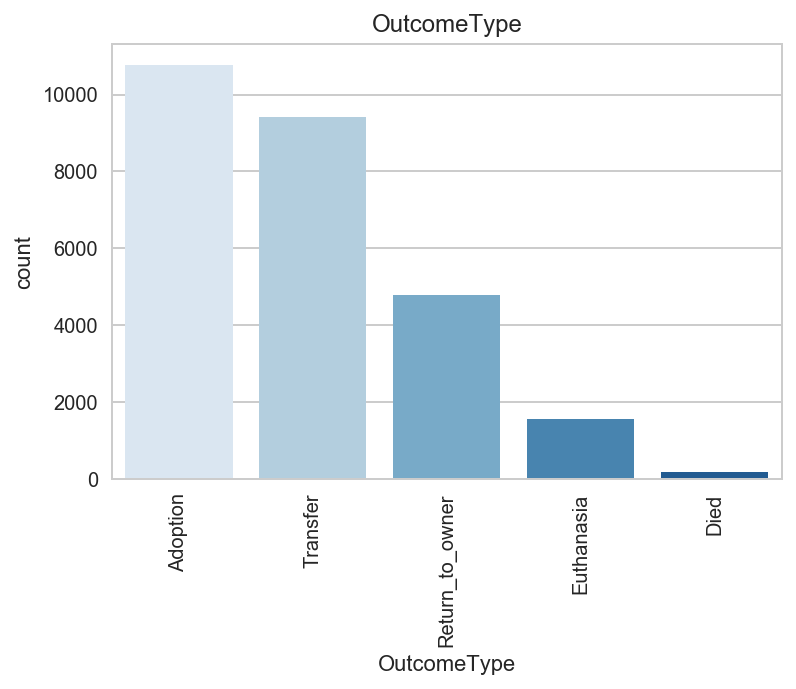

Adoption           10769
Transfer            9422
Return_to_owner     4786
Euthanasia          1555
Died                 197
Name: OutcomeType, dtype: int64

In [12]:
sns.countplot(x=train["OutcomeType"], data=train, palette="Blues" , order=train['OutcomeType'].value_counts().index)
plt.title('OutcomeType')
plt.xticks(rotation='vertical')
plt.show()
train["OutcomeType"].value_counts()

## 4-3. Preprocessing

In [10]:
# 전처리함수(수정가능)---------------
import datetime as dt

# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
train["OutcomeSubtype"] = train["OutcomeSubtype"].fillna("NoStatus")
train["SexuponOutcome"] = train["SexuponOutcome"].fillna("Unknown")
train["AgeuponOutcome"] = train["AgeuponOutcome"].fillna("-1 nodata")
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")



def preprocessShelter(df_raw):
    df = df_raw.copy()
    # Name --> Isname------------------------------------------
    df['Name'].fillna('Unknown', inplace=True)

    # 이름이 있으면 Has_name, 이름이 없으면 Unknown------------
    name = []
    for i in df['Name']:
        if i == 'Unknown':
            name.append('Unknown_name')
        else:
            name.append('Has_name')
    df['Name'] = name
    
    
    # color정리 - black, white, brown, others로 나눔
#     color = []
#     for i in df['Color']:
#         if i[:5] == 'Black':
#             color.append('Black')
#         elif i[:5] == 'White':
#             color.append('White')
#         elif i[:5] == 'Brown':
#             color.append('Brown')
#         else:
#             color.append('C_Others')
#     df['Color_1st'] = color    
    
    #--------------------------------------------1차 추가되는 컬럼정리(나이, 성별)
    
    df["sex_intact"] = (df["SexuponOutcome"].str.slice(0,6) == "Intact").astype(int)
    df["sex_unknown"] = (df["SexuponOutcome"] == "Unknown").astype(int)
    df["sex_mf"] = (df["SexuponOutcome"].str.split(' ', n=2, expand=True)[1] == "Male").astype(int)
    df.sex_mf[df["sex_unknown"]==1] = 2
    df.sex_intact[df["sex_unknown"]==1] = 2
    
    # 나이데이터 재정리 (Agenbr=나이의숫자만, Age_tscale=(day,week,month,year), Age_yscale=동물의 연생, 
    df["Age_nbr"] = df["AgeuponOutcome"].str.slice(0,2).astype(int) # 0인값의경우 해당 동물의 나이정보가 없는것으로 추정한다
    df["Age_tscale"] = df["AgeuponOutcome"].str.split(" ", n=2, expand=True)[1] # 띄어쓰기 된 뒷문장 가져오기
    df["Age_tscale"] = df["Age_tscale"].replace("s","",regex=True) # 문자 s를 삭제
    df["Age_yscale"] = df["Age_tscale"].replace(["day","week","month"],"under_year")
    df["Age_ynbr"] = df["Age_nbr"].copy()
    df.Age_ynbr[df["Age_yscale"]=="under_year"] = 0
    
    df["Age_daily_scale"] = 0
    df.Age_daily_scale[df['Age_tscale']=="day"] = 1
    df.Age_daily_scale[df['Age_tscale']=="week"] = 7
    df.Age_daily_scale[df['Age_tscale']=="month"] = 30
    df.Age_daily_scale[df['Age_tscale']=="year"] = 365
    df["Age_daily_scale"] = df["Age_daily_scale"]*df["Age_nbr"]

    # 어린친구, 성체, 나이든친구
    df["Age_code"] = 0
    df.Age_code[(df['Age_ynbr']>=1)|(df['Age_ynbr']<=3)] = 1
    df.Age_code[(df['Age_ynbr']>=4)] = 2
    
    # Breed 정제 - 1차 - 김민우
    df["Breed_Do"] = 0
    df["Breed_Mx"] = 0
    df["Breed_Lh"] = 0
    df["Breed_Mh"] = 0
    df["Breed_Sh"] = 0
    df["Breed_dogM"] = 0
    df.Breed_Do[df['Breed'].str.contains("Domestic", regex=True)] = 1
    df.Breed_Mx[df['Breed'].str.contains("Mix", regex=True)] = 1
    df.Breed_Lh[df['Breed'].str.contains("Longhair", regex=True)] = 1
    df.Breed_Sh[df['Breed'].str.contains("Shorthair", regex=True)] = 1
    df.Breed_Mh[df['Breed'].str.contains("MediumHair", regex=True)] = 1
    df.Breed_dogM[df['Breed'].str.contains("/", regex=True)] = 1
    df["Breed_extra"] = df["Breed"].replace(["Domestic","Mix"," ","Shorthair","Longhair","MediumHair",""],"",regex=True) # 문자 s를 삭제

    df["Breed_Pitbull"] = df["Breed_extra"].str.contains("PitBull",regex=True)

    # Breed 정제 - 2차 -정혜란님 아이디어
#     df["Breed_Sheepdog"] = 0 #쉐퍼드견 포함
#     df["Breed_Terrier"] = 0
#     df["Breed_Hound"] = 0
    
#     df["Breed_Chihuahua"] = 0
#     df["Breed_Pitbull"] = 0
#     df["Breed_Retriver"] = 0
#     df["Breed_Bullbog"] = 0
#     df["Breed_Poodle"] = 0
    
#     df["Breed_English"] = 0
#     df["Breed_American"] = 0
#     df["Breed_Chinese"] = 0
#     df["Breed_German"] = 0
#     df["Breed_OtherNT"] = 0
    


    # 시간데이터 정제
    temp = pd.to_datetime(df['DateTime'])
    df["Time_year"] = temp.dt.strftime("%Y").astype(int)
    df["Time_month"] = temp.dt.strftime("%m").astype(int)
    df["Time_DOW"] = temp.dt.dayofweek.astype(int)
    df["Time_day"] = temp.dt.strftime("%d").astype(int)
    df["Time_hour"] = temp.dt.strftime("%H").astype(int)
    df["Time_weekend"] = (df['Time_DOW'] >= 5).astype(int)
    df["Time_operating"] = 0
    df.Time_operating[(df['Time_hour']>=5)|(df['Time_hour']<=10)] = 1
    df.Time_operating[(df['Time_hour']>=11)|(df['Time_hour']<=15)] = 2
    df.Time_operating[(df['Time_hour']>=16)|(df['Time_hour']<=18)] = 3
    df.Time_operating[df['Time_hour']==19] = 4
    
    df["Time_season"] = ((df["Time_month"]%12)//3).astype(int)
    
    
    # 미 텍사스주 공휴일
    
    df["Holidays"] = 0
    df.Holidays[(df['Time_month']==1)&(df['Time_day']==19)]=1
    df.Holidays[(df['Time_month']==3)&(df['Time_day']==2)]=1
    df.Holidays[(df['Time_month']==4)&(df['Time_day']==21)]=1
    df.Holidays[(df['Time_month']==5)&(df['Time_day']==10)]=1
    df.Holidays[(df['Time_month']==6)&(df['Time_day']==19)]=1
    df.Holidays[(df['Time_month']==6)&(df['Time_day']>=18)&(df['Time_day']<=22)]=2
    df.Holidays[(df['Time_month']==8)&(df['Time_day']==27)]=1
    df.Holidays[(df['Time_month']==11)&(df['Time_day']==11)]=1
    df.Holidays[(df['Time_month']==11)&(df['Time_day']>=25)&(df['Time_day']<=27)]=2
    df.Holidays[(df['Time_month']==12)&(df['Time_day']>=23)&(df['Time_day']<=27)]=2
    
    return df




def preprocessColorBreed(df,Breed_dev):
    
    #Breed 정제 2차 - 전현일 - 코드최적화 김민우
#     df_B = pd.DataFrame()
#     ls = [i for data in list(df["Breed_extra"]) for i in data.split("/") ]
#     breeds = np.unique(ls)
#     for i in breeds[1:]:
#         df_B[i] = df['Breed_extra'].str.contains(i, regex=True).astype(int)
        
    #Breed 정제 3차 - 김민우,전현일,정혜란
    
    # 전처리 3단계 - 견종/묘종 특징 분류
#     list(df_breeds.columns)
#     breeds[:75] - 정혜란 조사
#     breeds[75:150] - 전현일 조사
#     breeds[150:] - 김민우 조사
    print("Breed_extra classificating..")

    df_B = pd.DataFrame(columns=["Breed_Life","Breed_Size", "Breed_Acti","Breed_Smrt","Breed_Frdy","Breed_Agsv"])
    df_B["Breed_Life"] = df["Name"].copy()# 갯수맞추기용
#     df_B["Breed_Size"] = 4
#     df_B["Breed_Acti"] = 2
#     df_B["Breed_Smrt"] = 2
#     df_B["Breed_Frdy"] = 2
#     df_B["Breed_Agsv"] = 2
    print("")
    cnt = 0
    for i in list(Breed_dev["Breed_extra"]):
        print(cnt,end=" ")
        df_B.Breed_Life[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Life)
        df_B.Breed_Size[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Size) 
        df_B.Breed_Acti[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Acti) 
        df_B.Breed_Smrt[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Smrt) 
        df_B.Breed_Frdy[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Frdy) 
        df_B.Breed_Agsv[df["Breed_extra"]==i] =  int(Breed_dev[Breed_dev["Breed_extra"]==i].Breed_Agsv) 
        cnt += 1

    # 믹스견의 경우 분배문제가 있음. ==> 둘중 하나라도 1이면 1로 본다. + 나이는 작은것을 채택한다.
    
    print("\nUnknown_name process...")
    for i,row in df.iterrows():
        if i%1000 == 0:
            print(i//1000,"..",end=" ")
        if "/" in row.Breed_extra: #.str.contains("/", regex=True):
            Lfe = 0
            Sze = 0
            Act = 0
            Smt = 0
            Fmy = 0
            Agr = 0
            count = 0
            for j in row.Breed_extra.split("/"):
                count += 1
                try:
                    Lfe += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Life)
                    Sze += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Size)
                    Act += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Acti)
                    Smt += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Smrt)
                    Fmy += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Frdy)
                    Agr += int(Breed_dev[Breed_dev["Breed_extra"]==j].Breed_Agsv)
                except :
                    print("no breed err:",i,end="")
                    count = 1
                    Lfe = 12
                    Sze = 4
                    Act = 0
                    Smt = 0
                    Fmy = 0
                    Agr = 0
                    break
                    
            df_B.set_value(i,"Breed_Life",int(Lfe // count))    
            df_B.set_value(i,"Breed_Size",int(Sze // count)) 
            df_B.set_value(i,"Breed_Acti",int(Act>0)) 
            df_B.set_value(i,"Breed_Smrt",int(Smt>0))
            df_B.set_value(i,"Breed_Frdy",int(Fmy>0))
            df_B.set_value(i,"Breed_Agsv",int(Agr>0))
            
    #예상 남은수명 계산
    try:
        df_B["Breed_RestLife"] = (df_B["Breed_Life"].astype(int)*365 - df["Age_daily_scale"])//365
    except:
        print("RestLife - err occured!")
        print("Breed_Life len : " ,len(df_B["Breed_Life"]))
        print("Agedaliy_scale len : " ,len(df["Age_daily_scale"]))
        print("dtype :",df_B.dtypes)
        return df_B, df_B
        print(df_B.Breed_Size.astype(int))
        print(df_B.Breed_Acti.astype(int))
        print(df_B.Breed_Smrt.astype(int))
        print(df_B.Breed_Frdy.astype(int))
        print(df_B.Breed_Agsv.astype(int))
        print(df_B.Breed_Life.astype(int))
        
        
    df_B = df_B.astype(int)
    
    print("\ncolor classificating...",end=" ")
    #Color 정제 2차 - 정혜란, 전현일
    df_C = pd.DataFrame()
    
    df_C["Color_mix"] = df["Color"].copy()
    df_C["Color_mix"] = 1
    df_C.Color_mix[df["Color"].str.contains("/|Sable|Seal Point|Lilac Point", regex=True)==True] = 2
    df_C.Color_mix[df["Color"].str.contains("Tricolor|Calico|Tortie|Torbie", regex=True)==True] = 3
    
    df_C["Color_extra"] = df["Color"].str.contains("Cream|Buff|Fawn|Apricot|Flame Point", regex=True).astype(int)
    df_C["Color_ful"] = df["Color"].str.contains("Blue|Red|Green", regex=True).astype(np.int8)
    df_C["Color_black"] = df["Color"].str.contains("Black", regex=True).astype(np.int8)
    df_C["Color_white"] = df["Color"].str.contains("White", regex=True).astype(np.int8)
    df_C["Color_gray"] = df["Color"].str.contains("Lynx|Gray|Silver", regex=True).astype(np.int8)
    df_C["Color_gold"] = df["Color"].str.contains("Orange|Yellow|Gold", regex=True).astype(np.int8)
    df_C["Color_brown"] = df["Color"].str.contains("Brown|Tan|Chocolate", regex=True).astype(np.int8)
    print("Complete!")
    
    return df_C, df_B #, breeds


#--------아래는 All카테고라이저, All원핫인코더 함수-------

from sklearn.preprocessing import LabelEncoder
def allCategorizer(df, columns=[]):

    print("Categorizing start... using ", columns)
    
    if len(columns) == 0:
        col_name = df.columns
        col_num = len(col_name)
    else :
        col_name = columns
        col_num = len(col_name)
    
    temp = df[col_name].copy()
    
    for i in range(col_num):
        le = LabelEncoder()
        y = temp[col_name[i]]
        le.fit(y)
        temp[col_name[i]] = le.transform(y)
        print(i,", ",end="")
    print("Complete!")
    return temp.astype(np.int8)        
        
def allOneHotEncoder(df, columns=[]):
    print("One_Hot_Encoding start... using ", columns)

    if len(columns) == 0:
        col_name = df.columns
        col_num = len(col_name)
    else :
        col_name = columns
        col_num = len(col_name)
        
    for i in range(col_num):
        temp = pd.get_dummies(df[col_name[i]])
        if i == 0 : 
            onehot_df = temp.copy()
            print(i,", ",end="")
        else : 
            onehot_df = pd.concat([onehot_df,temp], axis=1)
            print(i,", ",end="")
    print("Complete!")
    return onehot_df



# 전처리된 데이터프레임 설정 --> df_train -------------------

df_train = preprocessShelter(train)
df_colors, df_breeds = preprocessColorBreed(df_train,Breed_dev)
df_train2 = pd.concat([df_train, df_breeds,df_colors],axis=1) 


# 비율 그래프 함수

counts = df_train.groupby(['AnimalType', 'OutcomeType']).count()
counts = counts.reset_index()
del counts['AnimalType']

def show_differences(x): # x = column 이름
    c = np.sum(counts[x][5:10])
    d = np.sum(counts[x][0:5])
    Adoption = [counts[x][5]/c, counts[x][0]/d]
    Died = [counts[x][6]/c, counts[x][1]/d]
    Euthanasia = [counts[x][7]/c, counts[x][2]/d]
    Return_to_owner = [counts[x][8]/c, counts[x][3]/d]
    Transfer = [counts[x][9]/c, counts[x][4]/d]
    
    df = pd.DataFrame({"Adoption" : Adoption, "Died" : Died, "Euthanasia" : Euthanasia, "Return_to_owner" : Return_to_owner, "Transfer" : Transfer})
    df.plot(kind='barh', stacked=True)
    plt.legend(bbox_to_anchor=(1.1,1.05))
    
    a, b = 0, 0
    for i in range(5):
        plt.xlim(0,1)
        if np.round((counts[x][5+i]/c)*100) > 1:
            plt.text(a + (counts[x][i+5]/(2*c))-0.023,0, np.round((counts[x][5+i]/c)*100))
        a += (counts[x][5+i])/c
        if np.round((counts[x][i]/d)*100) >1:
            plt.text(b + (counts[x][i]/(2*d))-0.023,1, np.round((counts[x][i]/d)*100))
        b += (counts[x][i])/d

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

Breed_extra classificating..

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 
Unknown_name process...
0 .. 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:212: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:213: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:214: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:215: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:216: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipyker

1 .. 2 .. 3 .. 4 .. 5 .. 6 .. 7 .. 8 .. 9 .. 10 .. 11 .. 12 .. 13 .. 14 .. 15 .. 16 .. 17 .. 18 .. 19 .. 20 .. 21 .. 22 .. 23 .. 24 .. 25 .. 26 .. 
color classificating... Complete!


In [17]:
counts = df_train.groupby(['AnimalType', 'OutcomeType']).count()
counts = counts.reset_index()
del counts['AnimalType']

def show_differences(x): # x = column 이름
    c = np.sum(counts[x][5:10])
    d = np.sum(counts[x][0:5])
    Adoption = [counts[x][5]/c, counts[x][0]/d]
    Died = [counts[x][6]/c, counts[x][1]/d]
    Euthanasia = [counts[x][7]/c, counts[x][2]/d]
    Return_to_owner = [counts[x][8]/c, counts[x][3]/d]
    Transfer = [counts[x][9]/c, counts[x][4]/d]
    
    df = pd.DataFrame({"Adoption" : Adoption, "Died" : Died, "Euthanasia" : Euthanasia, "Return_to_owner" : Return_to_owner, "Transfer" : Transfer})
    df.plot(kind='barh', stacked=True)
    plt.legend(bbox_to_anchor=(1.1,1.05))
    
    a, b = 0, 0
    for i in range(5):
        plt.xlim(0,1)
        if np.round((counts[x][5+i]/c)*100) > 1:
            plt.text(a + (counts[x][i+5]/(2*c))-0.023,0, np.round((counts[x][5+i]/c)*100))
        a += (counts[x][5+i])/c
        if np.round((counts[x][i]/d)*100) >1:
            plt.text(b + (counts[x][i]/(2*d))-0.023,1, np.round((counts[x][i]/d)*100))
        b += (counts[x][i])/d

### 4-3-1. OutcomeSubtype

In [14]:
train.groupby("OutcomeSubtype").size().reset_index(name='count').sort_values('count', ascending=False)

,OutcomeSubtype,count
11,NoStatus,13612
13,Partner,7816
6,Foster,1800
15,SCRP,1599
16,Suffering,1002
0,Aggressive,320
12,Offsite,165
8,In Kennel,114
3,Behavior,86
14,Rabies Risk,74


### 4-3-2. Name

In [15]:
train.groupby("Name").size().reset_index(name='count').sort_values('count',ascending=False)

,Name,count
3683,Max,136
440,Bella,135
1056,Charlie,107
1450,Daisy,106
3456,Lucy,94
788,Buddy,87
4690,Princess,86
4953,Rocky,85
3476,Luna,68
2618,Jack,66


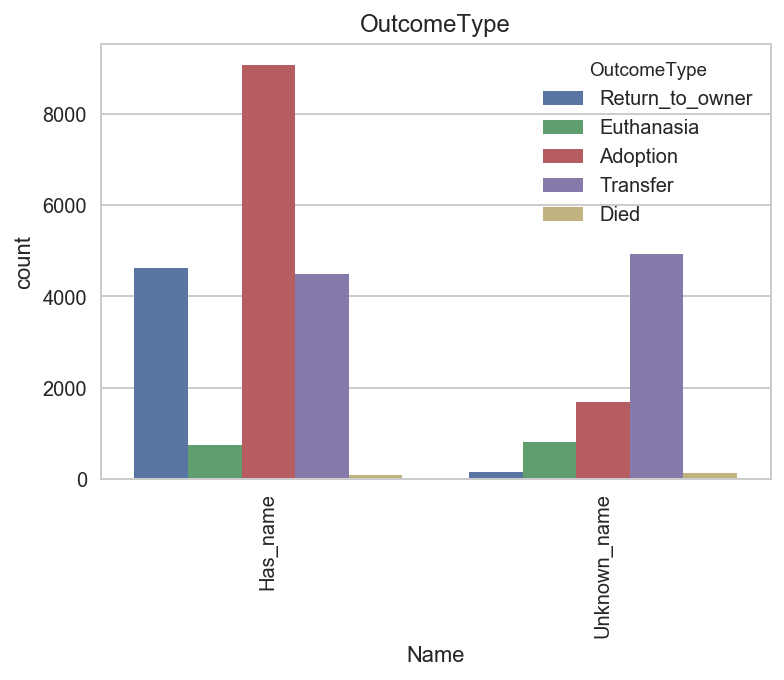

In [19]:
# 이름이 있는 경우 어덥션 높고 이름 없는 경우 transfer 높다.
sns.countplot(x="Name", data=df_train , hue ='OutcomeType')
plt.title('OutcomeType')
plt.xticks(rotation='vertical')

plt.show()

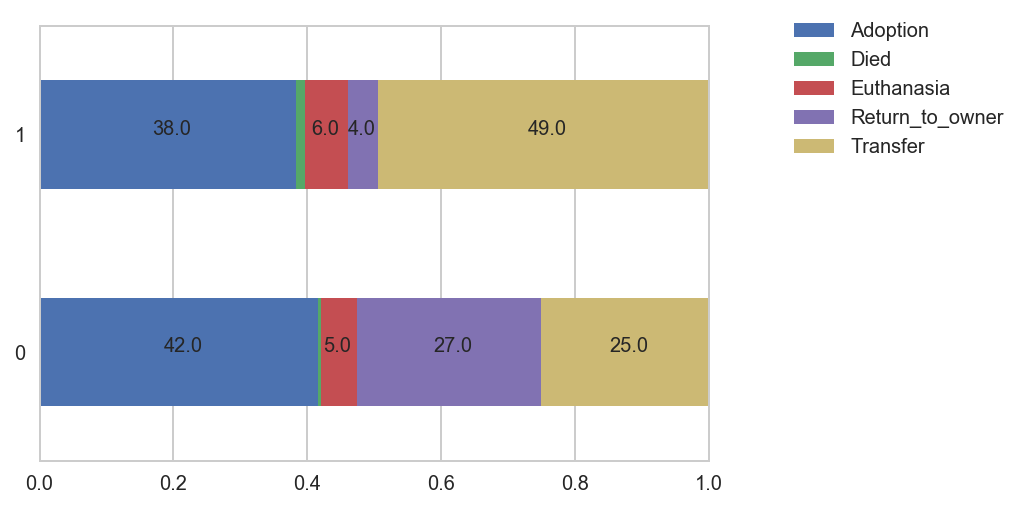

In [20]:
show_differences('Name')
plt.show()

### 4-3-3. AnimalType

In [17]:
train.groupby("AnimalType").size().reset_index(name='count').sort_values('count',ascending=False)

,AnimalType,count
1,Dog,15595
0,Cat,11134


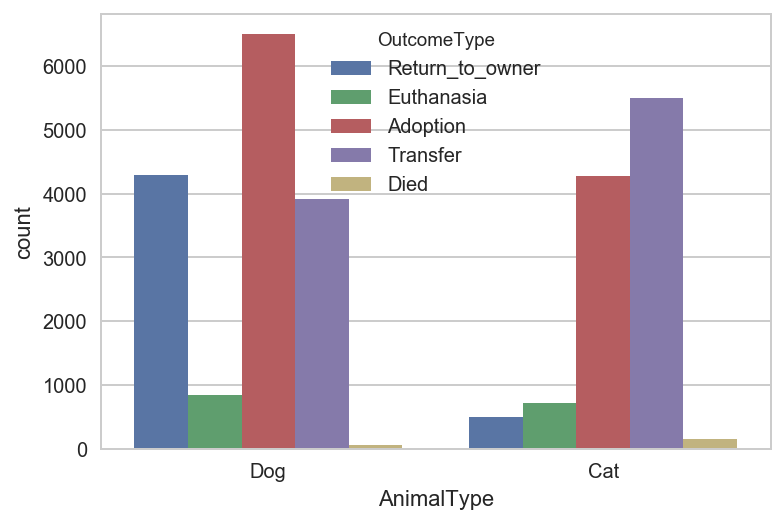

In [18]:
sns.countplot(x='AnimalType',data=df_train, hue='OutcomeType')
plt.show()

### 4-3-4. SexuponOutcome

In [19]:
train.groupby("SexuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False)

,SexuponOutcome,count
2,Neutered Male,9779
3,Spayed Female,8820
1,Intact Male,3525
0,Intact Female,3511
4,Unknown,1094


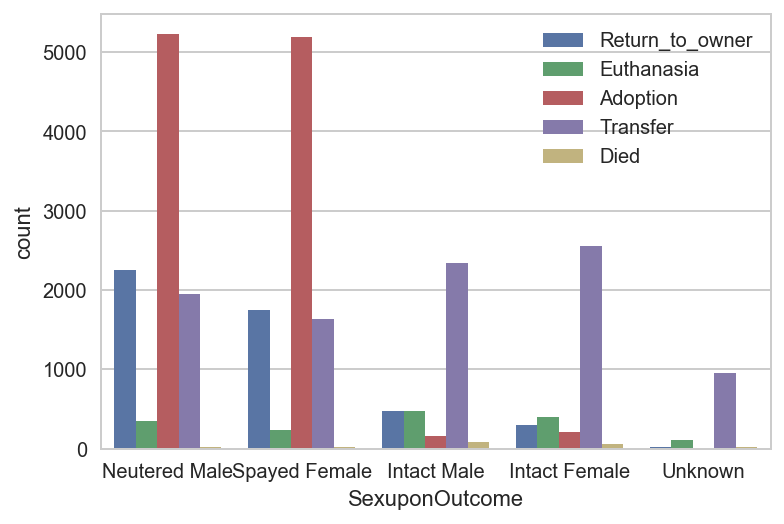

In [20]:
# 중성화 된 동물들의 어덥션이 높고 중성화 되지 않은 동물들이 transfer 된 경우가 많음
sns.countplot(x='SexuponOutcome',data=train, hue='OutcomeType')
plt.legend(loc='upper right')
plt.show()

### 4-3-5. AgeuponOutcome(10개만 표시)

In [21]:
train.groupby("AgeuponOutcome").size().reset_index(name='count').sort_values('count', ascending=False).head(10)

,AgeuponOutcome,count
6,1 year,3969
22,2 years,3742
20,2 months,3397
27,3 years,1823
3,1 month,1281
25,3 months,1277
31,4 years,1071
35,5 years,992
29,4 months,888
38,6 years,670


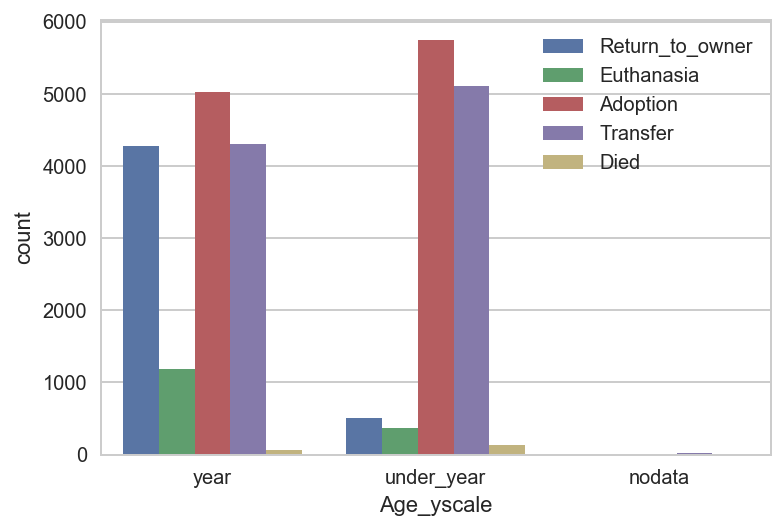

In [22]:
# 1살 이상의 동물들이 주인에게 돌아가는 경우가 많다.
sns.countplot(x='Age_yscale',data=df_train, hue='OutcomeType')
plt.legend(loc='upper right')
plt.show()

### 나이 정보가 없는 경우

In [23]:
train[train["AgeuponOutcome"].isnull() == True]

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color


In [24]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
train["OutcomeSubtype"] = train["OutcomeSubtype"].fillna("NoStatus")
train["SexuponOutcome"] = train["SexuponOutcome"].fillna("Unknown")
train["AgeuponOutcome"] = train["AgeuponOutcome"].fillna("-1 nodata")
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")


### 4-3-6. Breed(15개만 표시)

In [25]:
train.groupby("Breed").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

,Breed,count
640,Domestic Shorthair Mix,8810
1066,Pit Bull Mix,1906
450,Chihuahua Shorthair Mix,1766
847,Labrador Retriever Mix,1363
637,Domestic Medium Hair Mix,839
696,German Shepherd Mix,575
632,Domestic Longhair Mix,520
1251,Siamese Mix,389
74,Australian Cattle Dog Mix,367
559,Dachshund Mix,318


### 4-3-7. Color(15개만 표시)

In [26]:
train.groupby("Color").size().reset_index(name='count').sort_values('count', ascending=False).head(15)

,Color,count
38,Black/White,2824
5,Black,2292
104,Brown Tabby,1635
111,Brown Tabby/White,940
318,White,931
130,Brown/White,884
216,Orange Tabby,841
289,Tan/White,773
307,Tricolor,752
86,Blue/White,702


In [27]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
train["OutcomeSubtype"] = train["OutcomeSubtype"].fillna("NoStatus")
train["SexuponOutcome"] = train["SexuponOutcome"].fillna("Unknown")
train["AgeuponOutcome"] = train["AgeuponOutcome"].fillna("-1 nodata")
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")


### 견종, 묘종 특징 컬럼 생성

## 4-2. Feature Engineering & Analysis

### - 비정형 데이터 --> 반정형화(정리) --> 정형화(OHE,Categorizing)

In [28]:
# print(df_train.columns,"\n")
# print(df_breeds.columns,"\n")
# print(df_colors.columns)
# df_train.describe().T
df_train.tail()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,sex_intact,sex_unknown,sex_mf,Age_nbr,Age_tscale,Age_yscale,Age_ynbr,Age_daily_scale,Age_code,Breed_Do,Breed_Mx,Breed_Lh,Breed_Mh,Breed_Sh,Breed_dogM,Breed_extra,Breed_Pitbull,Time_year,Time_month,Time_DOW,Time_day,Time_hour,Time_weekend,Time_operating,Time_season,Holidays
26724,A702446,Unknown_name,2015-05-14 11:56:00,Transfer,Partner,Cat,Intact Male,1 month,Domestic Shorthair Mix,Brown Tabby/White,1,0,1,1,month,under_year,0,30,1,1,1,0,0,1,0,,False,2015,5,3,14,11,0,3,1,0
26725,A718934,Unknown_name,2016-01-20 18:59:00,Transfer,SCRP,Cat,Spayed Female,3 months,Domestic Shorthair Mix,Brown Tabby,0,0,0,3,month,under_year,0,90,1,1,1,0,0,1,0,,False,2016,1,2,20,18,0,3,0,0
26726,A698128,Has_name,2015-03-09 13:33:00,Adoption,NoStatus,Dog,Neutered Male,4 years,Old English Bulldog Mix,White/Tan,0,0,1,4,year,year,4,1460,2,0,1,0,0,0,0,OldEnglishBulldog,False,2015,3,0,9,13,0,3,1,0
26727,A677478,Unknown_name,2014-04-27 12:22:00,Transfer,Partner,Cat,Intact Male,4 weeks,Domestic Shorthair Mix,Black,1,0,1,4,week,under_year,0,28,1,1,1,0,0,1,0,,False,2014,4,6,27,12,1,3,1,0
26728,A706629,Unknown_name,2015-07-02 09:00:00,Transfer,SCRP,Cat,Intact Male,1 year,Domestic Shorthair Mix,Brown Tabby/White,1,0,1,1,year,year,1,365,1,1,1,0,0,1,0,,False,2015,7,3,2,9,0,3,2,0


### - AgeuponOutcome & OutcomeType

동물의 나이별(년) 개체수 통계


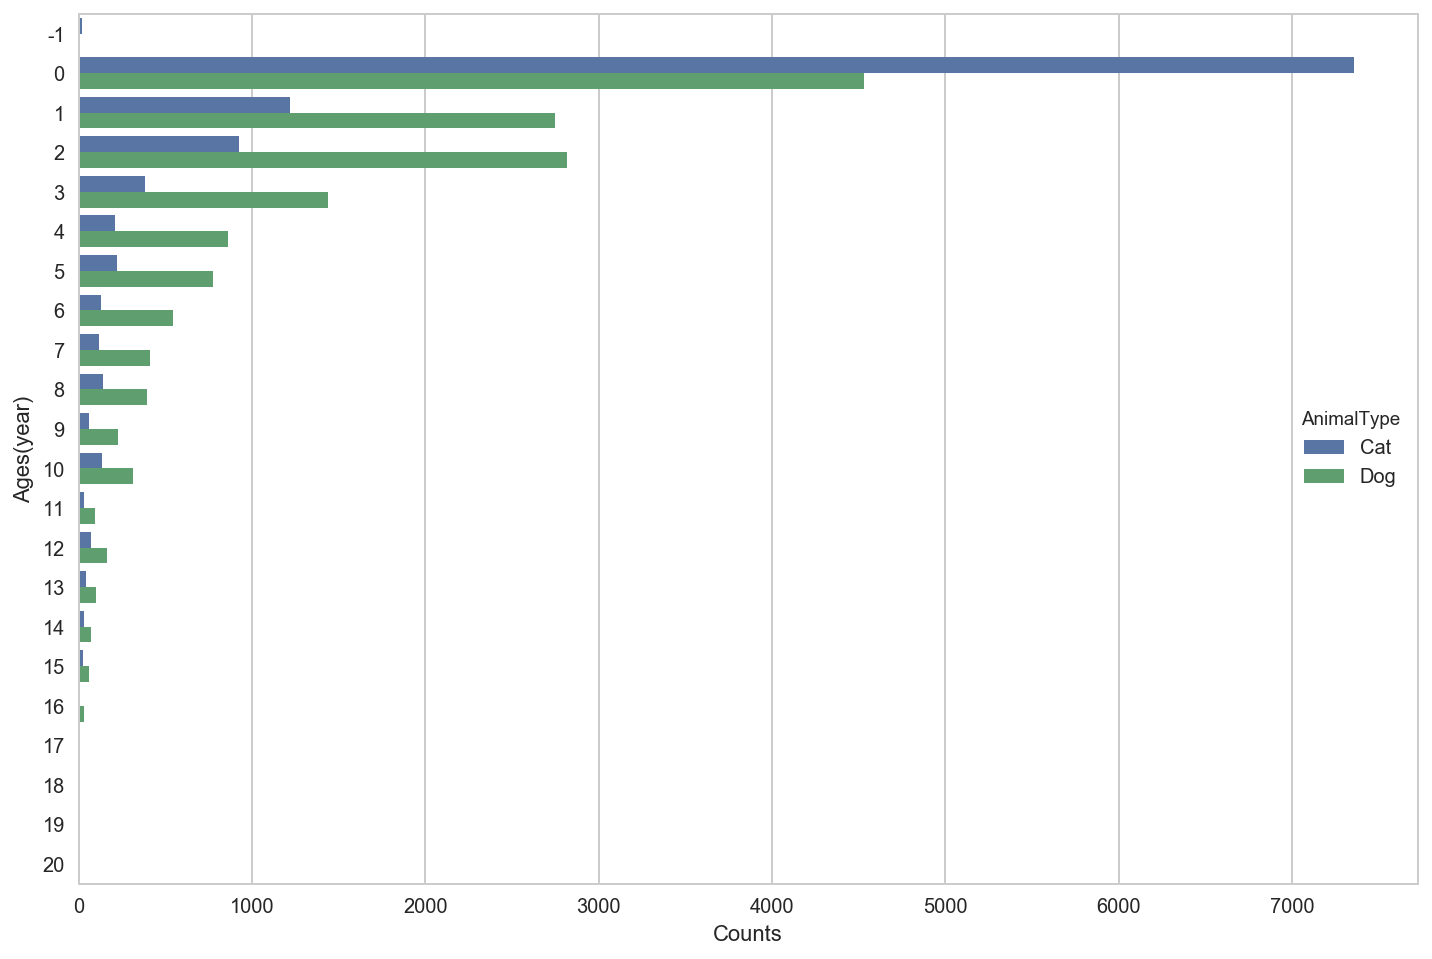

In [29]:
# 위 그래프 정제결과1 : 동
sorted_df = df_train.groupby(["Age_ynbr","AnimalType"]).size().reset_index(name="count")
sorted_df['Age_ynbr'] = pd.Categorical(sorted_df['Age_ynbr'])
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="Age_ynbr", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('Ages(year)')
print("동물의 나이별(년) 개체수 통계")

### - Color & OutcomeType

동물의 처리결과별 - 특징 통계


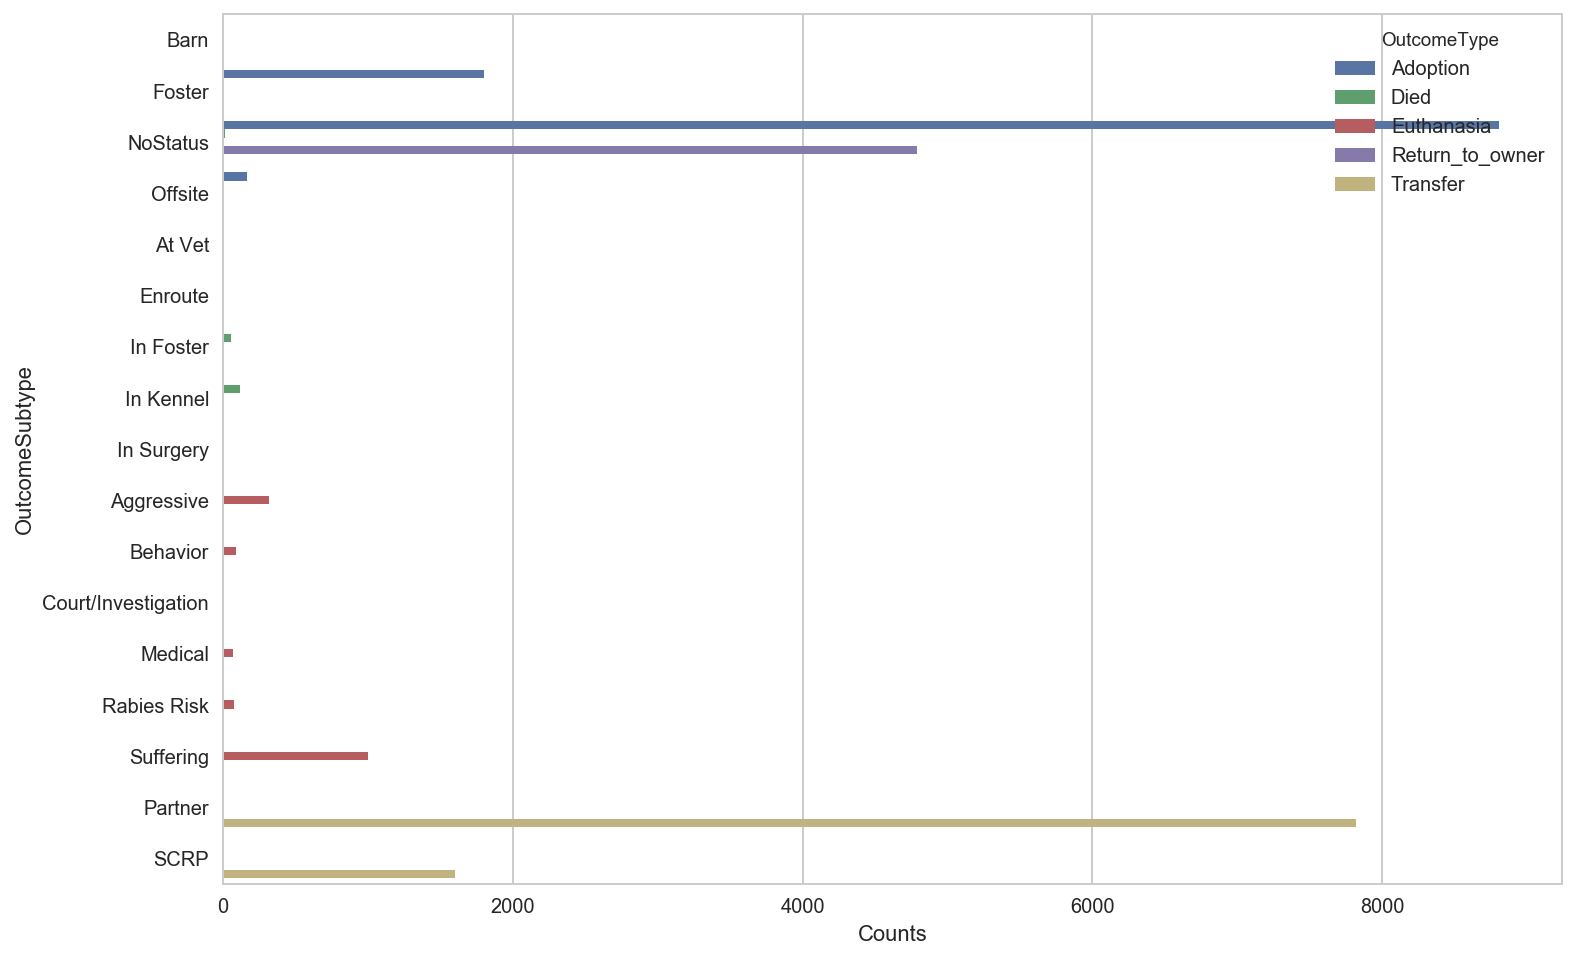

In [30]:
sorted_df = df_train.groupby(["OutcomeType","OutcomeSubtype"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeSubtype", hue="OutcomeType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeSubtype')
print("동물의 처리결과별 - 특징 통계")

### 5-6. Breed

- 개, 고양이의 종류

In [31]:
extra = df_train.groupby('Breed_extra').size().reset_index(name="count").sort_values("count",ascending=False)
extra.head(10)

,Breed_extra,count
0,,10377
396,Chihuahua,2002
939,PitBull,1972
739,LabradorRetriever,1432
604,GermanShepherd,652
1105,Siamese,413
490,Dachshund,405
71,AustralianCattleDog,392
282,Boxer,275
846,MiniaturePoodle,254


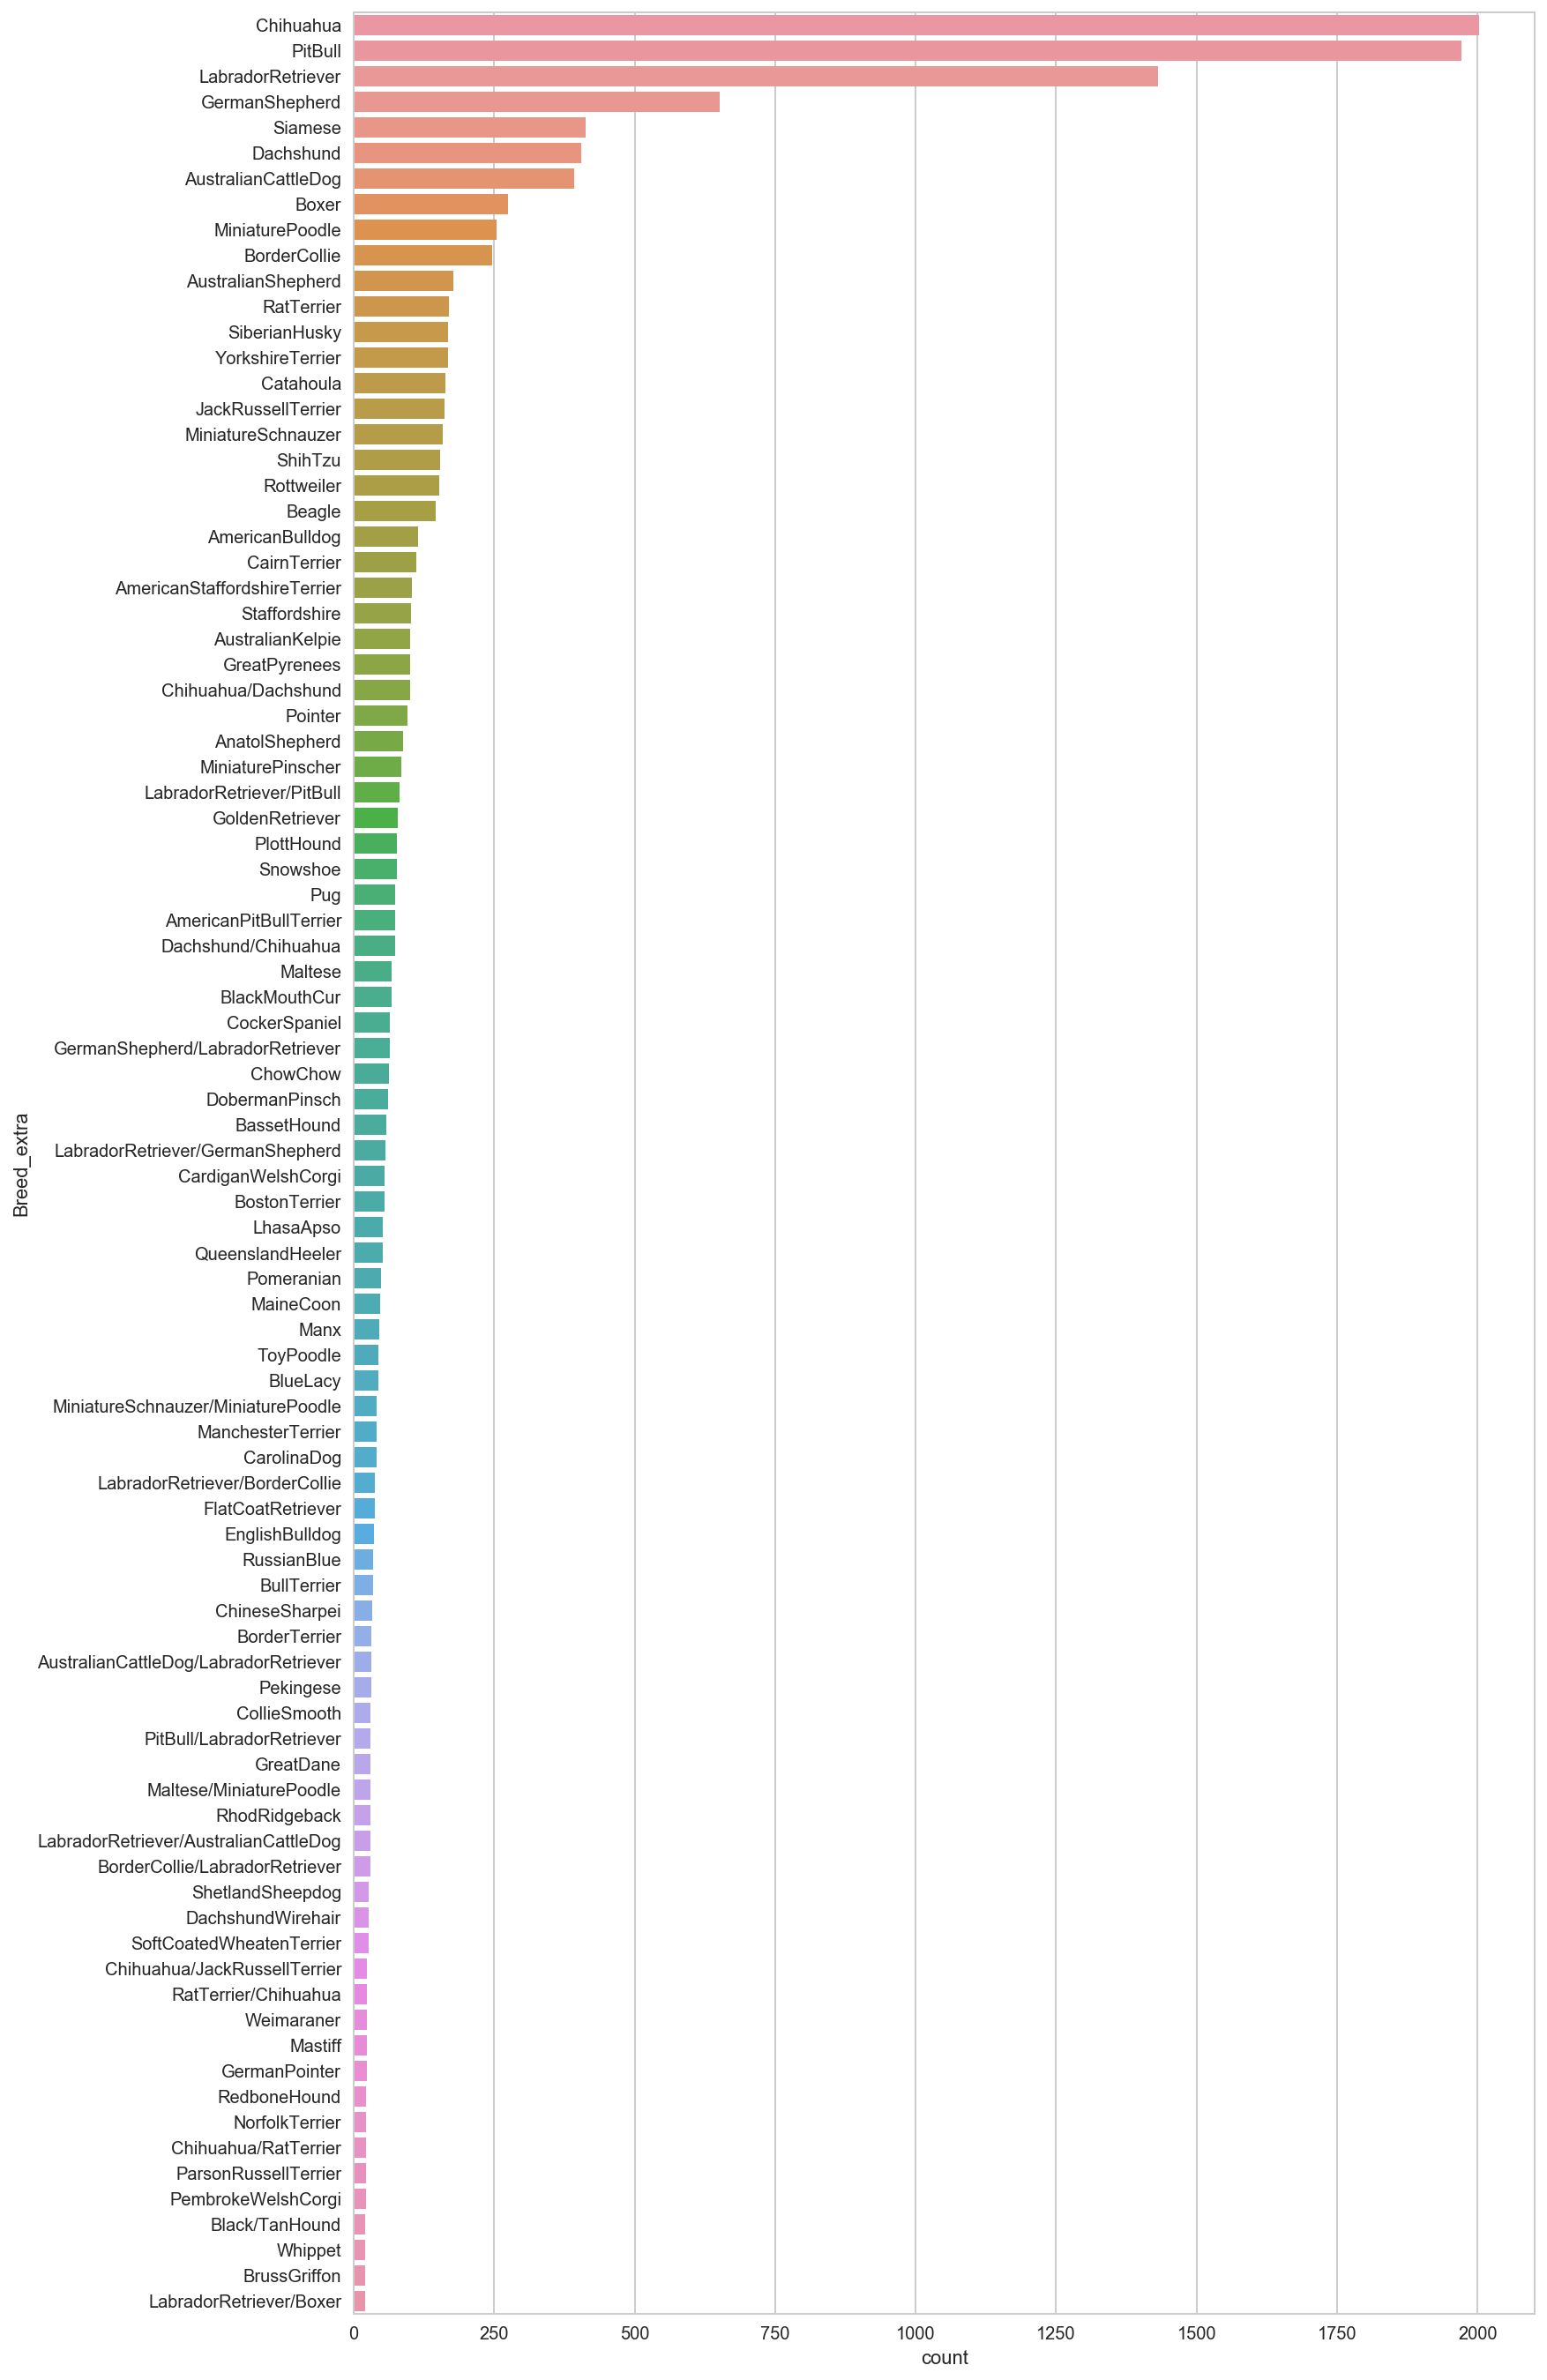

In [32]:
plt.figure(figsize=(12,24))
sns.barplot(x="count",y="Breed_extra",data=extra[(extra["count"]>20)&(extra["count"]<3000)])

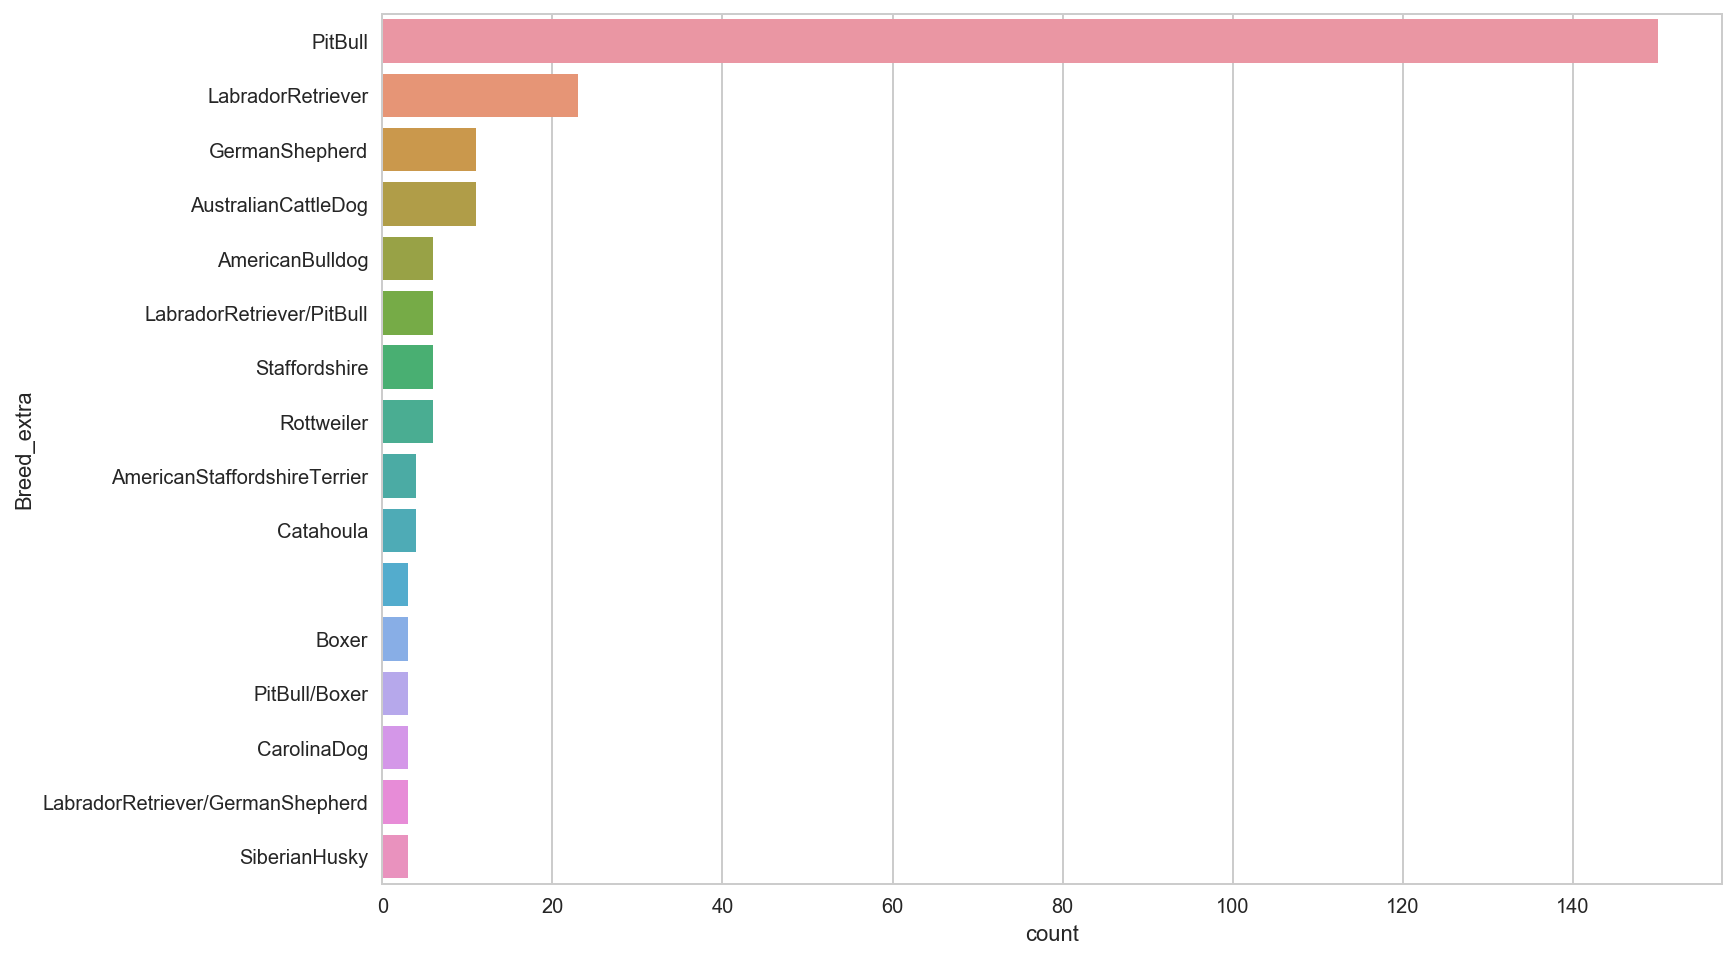

In [33]:
temp = df_train[df_train["OutcomeSubtype"]=="Aggressive"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>2])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

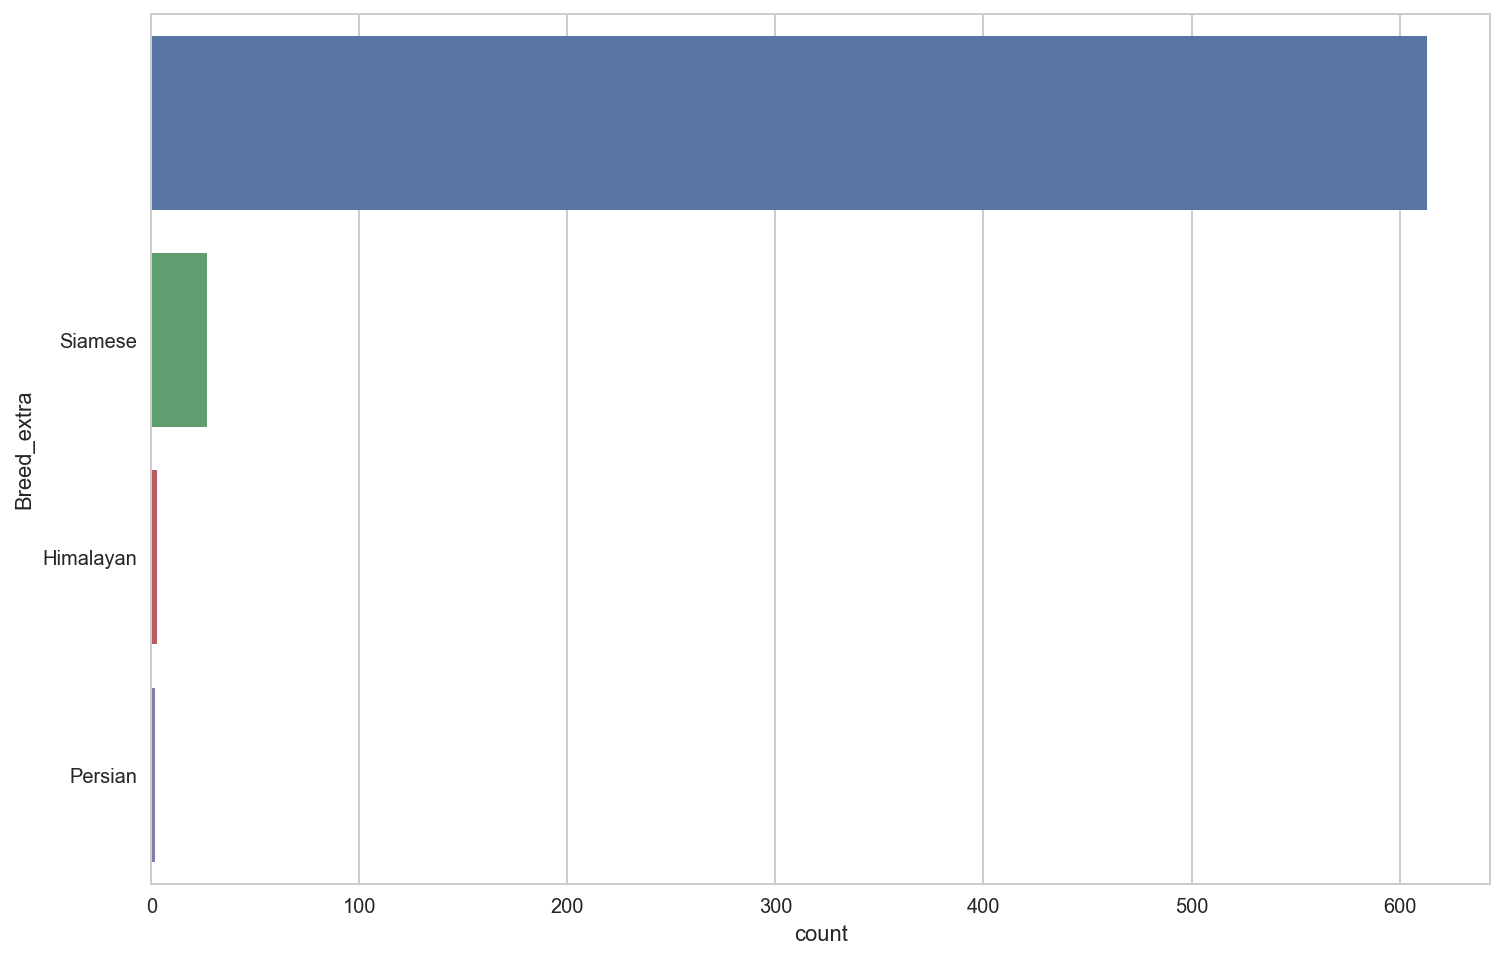

In [34]:
temp = df_train[df_train["OutcomeSubtype"]=="Suffering"]
temp = temp[temp["AnimalType"]=="Cat"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>1])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

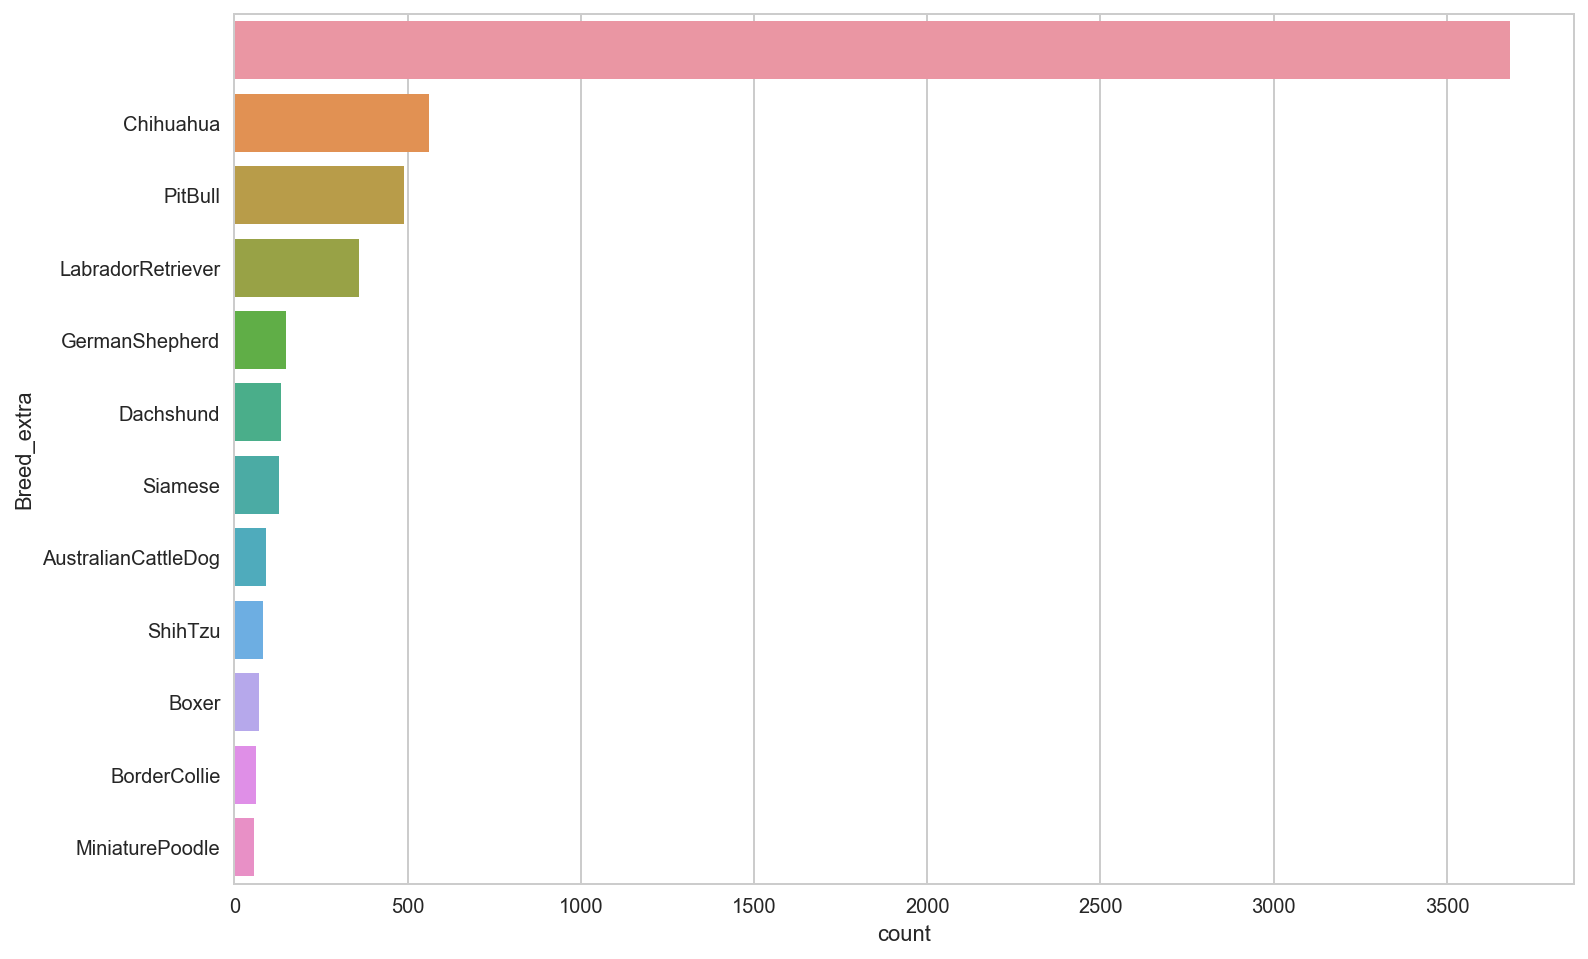

In [35]:
temp = df_train[df_train["OutcomeSubtype"]=="Partner"]
temp = temp.groupby('Breed_extra').size().reset_index(name='count').sort_values("count",ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x='count',y='Breed_extra',data=temp[temp["count"]>50])

# tmp = df_train.copy()
# tmp.Breed_extra[tmp["Breed_extra"].str.contains("PitBull") == True].count()

[]

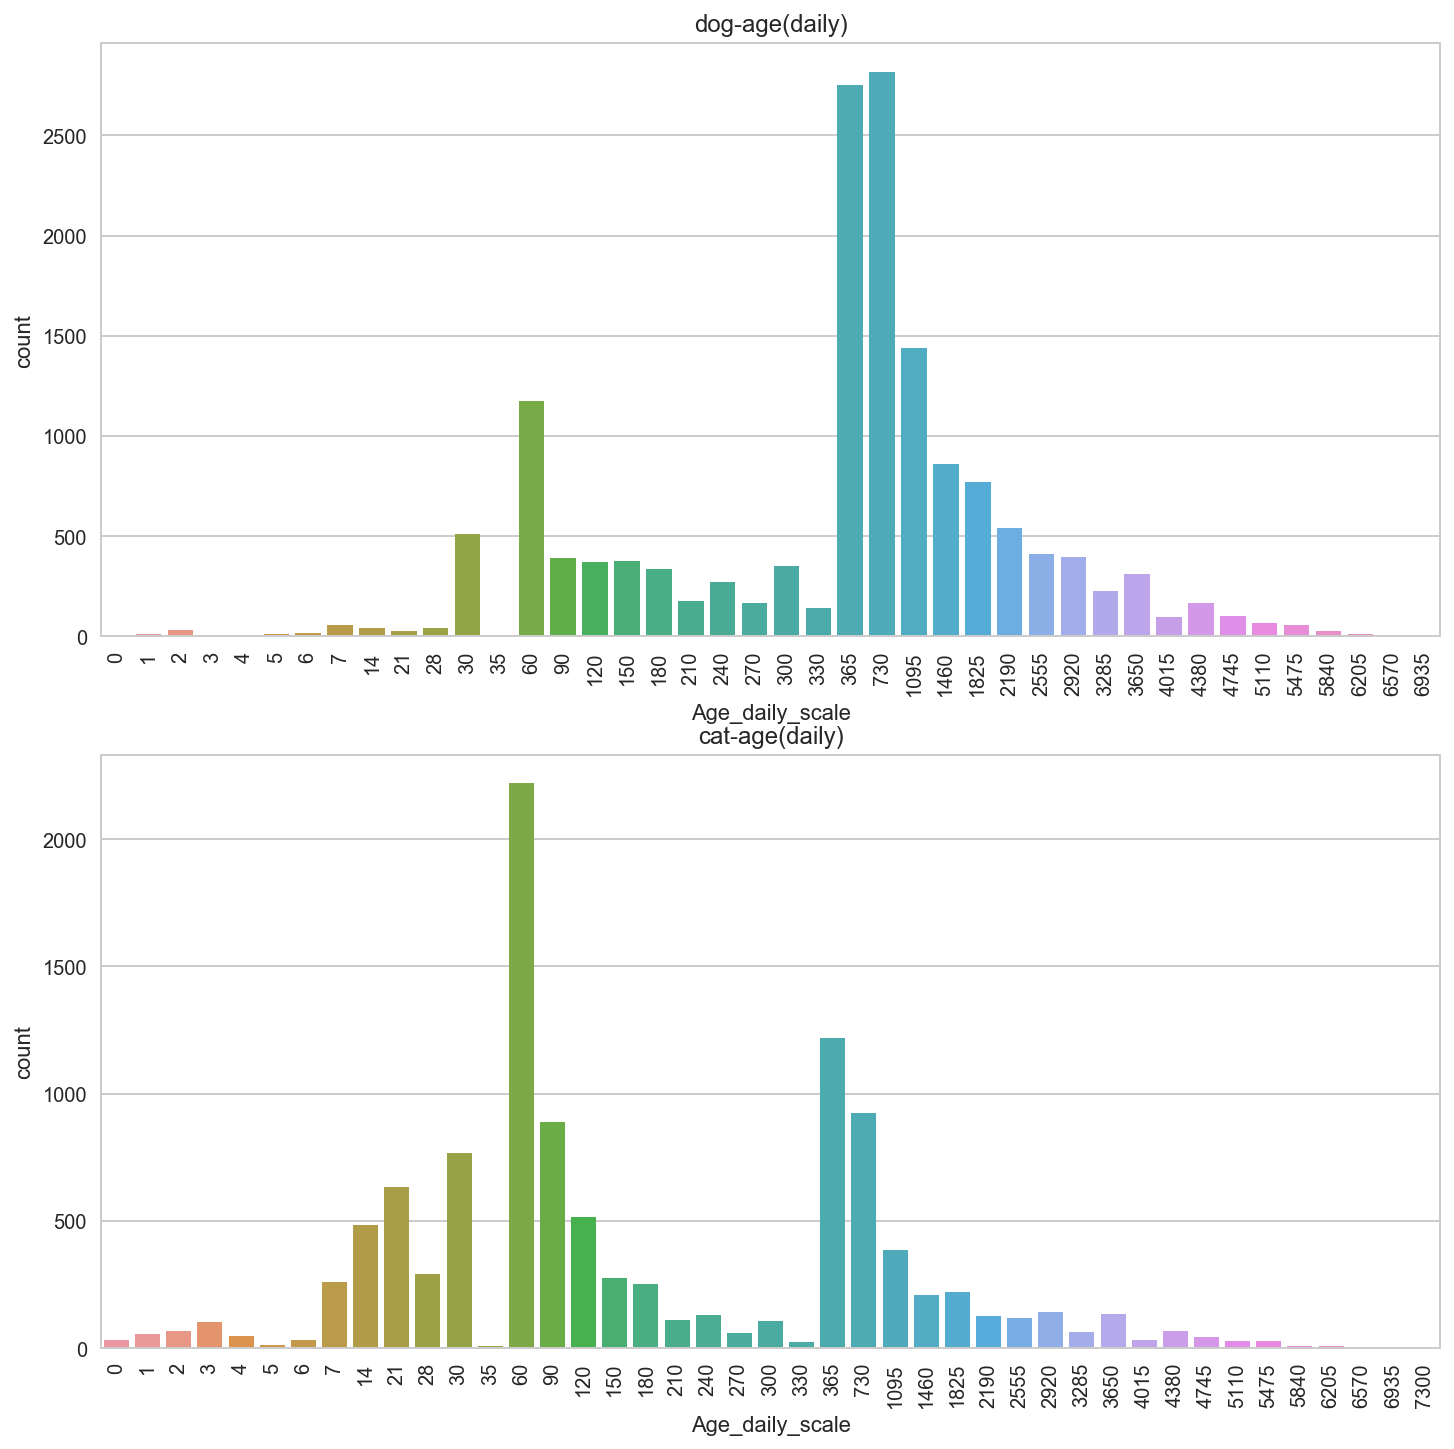

In [36]:
temp1 = df_train[df_train["AnimalType"]=="Dog"]
temp1 = temp1.groupby('Age_daily_scale').size().reset_index(name="count")#.sort_values("count",ascending=False)

temp2 = df_train[df_train["AnimalType"]=="Cat"]
temp2 = temp2.groupby('Age_daily_scale').size().reset_index(name="count")#.sort_values("count",ascending=False)

plt.figure(figsize=(12,12))
plt.subplot(211)
sns.barplot(data=temp1, x='Age_daily_scale',y='count').set_title("dog-age(daily)")
plt.xticks(rotation="vertical")
plt.subplot(212)
sns.barplot(data=temp2, x='Age_daily_scale',y='count').set_title("cat-age(daily)")
plt.xticks(rotation="vertical")
plt.plot()

## 6. Classification Modeling - Cross Validation
0. 나이브 베이지안
1. 의사결정나무
2. 랜덤포레스트
3. XGBoost
4. 앙상블 = 랜덤포레스트 + XGBoost
5. 신경망 - keras

### 분석용 변수 설정

In [37]:
#사전조건 설정 (고양이 or 개)
train_if = train.copy()
# train_if = train[train["AnimalType"]=="Cat"].copy()
# train_if = train[train["AnimalType"]=="Dog"].copy()

In [38]:
# y값 카테고리화
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = train_if['OutcomeType']
le.fit(y)
y= le.transform(y)
y

array([3, 2, 0, ..., 0, 4, 4])

In [39]:
le.classes_

array(['Adoption', 'Died', 'Euthanasia', 'Return_to_owner', 'Transfer'],
      dtype=object)

In [41]:
#분석할 컬럼들
# cols1= ['Name', 'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Color']

#강아지용
cols2=['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType',
       'Age_daily_scale', 'Age_code',
       'Breed_dogM', 'Breed_Mx', 'Breed_Do', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 
       'Breed_Pitbull', #'Breed_extra',
       'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', 'Time_weekend', #'Time_day'
#        'Time_operating',
       'Time_season', 'Holidays'
      ]

#고양이용
# cols2=['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType',
#        'Age_daily_scale', 'Age_code',
#        'Breed_dogM', 'Breed_Mx', #'Breed_Do', #'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_extra','Breed_Pitbull',
#        'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour',
#        'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']


df_train2 = preprocessShelter(train_if)
df_colors2, df_breeds2 = preprocessColorBreed(df_train2,Breed_dev)

# df_OHE = allOneHotEncoder(df_train2,cols2)
df_Ctg = allCategorizer(df_train2,cols2)
# temp.head(20)
# df_train[cols]
df_final = pd.concat([df_Ctg, df_breeds2],axis=1)# ,df_colors2
# cols_f = len(df_final.columns)
df_final = df_final[['Name', 'sex_intact', #'sex_unknown',
                     'sex_mf', 'AnimalType', 'Age_daily_scale',
                     #'Age_code',
                     'Breed_dogM', 'Breed_Mx',
                     'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                     'Breed_Pitbull',
                     'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                     'Time_season', #'Holidays', 
                     'Breed_RestLife', 'Breed_Life', 'Breed_Agsv', 'Breed_Size',  #'Breed_Acti',
                     'Breed_Smrt', #'Breed_Frdy'
                    ]]
# df_final.columns
#성능이 좋은 세팅
# 고양이 : 

# 강아지 : 카테고리종 한군데 분류
# cols2=['Name', 'AnimalType', 'sex_intact', 'sex_unknown', 'sex_mf',
#        'Age_daily_scale', 'Age_code',
#        'Breed_Do', 'Breed_Mx', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_dogM','Breed_extra','Breed_Pitbull',
#        'Time_year', 'Time_month', 'Time_DOW', 'Time_day', 'Time_hour',
#        'Time_weekend', 'Time_operating', 'Time_season', 'Holidays']
# df_final = pd.concat([df_Ctg,df_colors2],axis=1)# , df_breeds2
# 결합형

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

Breed_extra classificating..

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 
Unknown_name process...
0 .. 

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:212: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:213: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:214: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:215: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:216: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/usr/local/lib/python3.6/site-packages/ipyker

1 .. 2 .. 3 .. 4 .. 5 .. 6 .. 7 .. 8 .. 9 .. 10 .. 11 .. 12 .. 13 .. 14 .. 15 .. 16 .. 17 .. 18 .. 19 .. 20 .. 21 .. 22 .. 23 .. 24 .. 25 .. 26 .. 
color classificating... Complete!
Categorizing start... using  ['Name', 'sex_intact', 'sex_unknown', 'sex_mf', 'AnimalType', 'Age_daily_scale', 'Age_code', 'Breed_dogM', 'Breed_Mx', 'Breed_Do', 'Breed_Lh', 'Breed_Mh', 'Breed_Sh', 'Breed_Pitbull', 'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', 'Time_weekend', 'Time_season', 'Holidays']
0 , 1 , 2 , 3 , 4 , 5 , 6 , 7 , 8 , 9 , 10 , 11 , 12 , 13 , 14 , 15 , 16 , 17 , 18 , 19 , 20 , Complete!


### 의사결정나무 + cv

model creating.., 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11
model testing...
Tree Model1: CV Mean score: 0.608 --- acuraccy score : 0.608
Tree Model2: CV Mean score: 0.608 --- acuraccy score : 0.608
Tree Model3: CV Mean score: 0.608 --- acuraccy score : 0.608
Tree Model4: CV Mean score: 0.618 --- acuraccy score : 0.621
Tree Model5: CV Mean score: 0.634 --- acuraccy score : 0.636
Tree Model6: CV Mean score: 0.651 --- acuraccy score : 0.661
Tree Model7: CV Mean score: 0.666 --- acuraccy score : 0.675
Tree Model8: CV Mean score: 0.671 --- acuraccy score : 0.683
Tree Model9: CV Mean score: 0.672 --- acuraccy score : 0.694
Tree Model10: CV Mean score: 0.667 --- acuraccy score : 0.706
Tree Model11: CV Mean score: 0.662 --- acuraccy score : 0.725


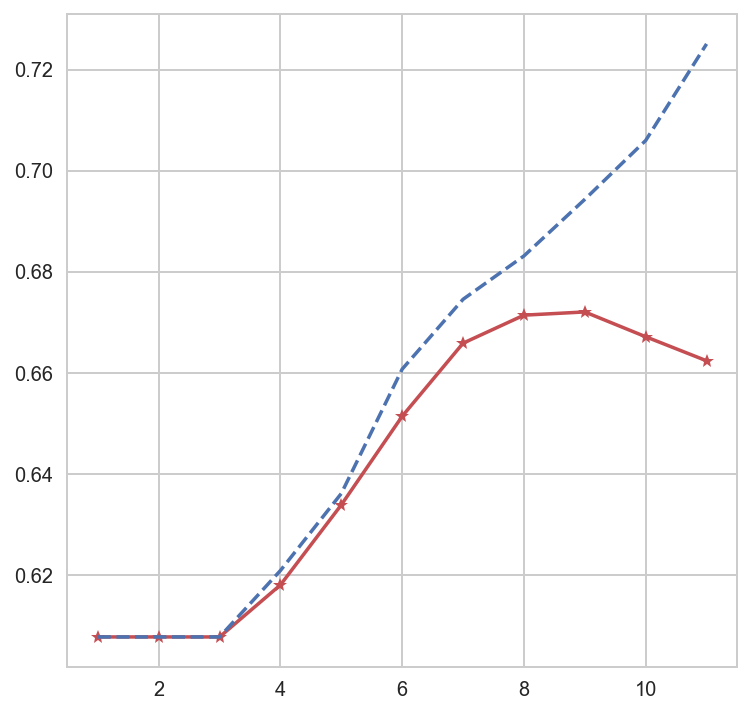

In [43]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
tree_ls = []
score_ls = []
accur_ls = []

# tree 모델 자동생성 반복문
print("model creating..",end="")
for i in range(1,12):
    tree = DecisionTreeClassifier(criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    tree_ls.append(tree)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(tree_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("Tree Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
# 고양이 : 0.787 - depth : 5
# 강아지 : 0.583 - depth : 9 (Breed 간략화) --> 0.585 - depth : 8 (Breed 세분화)
# 결합기록 : 0.673 - depth : 9 -(Color 제거)

In [44]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
Tree = DecisionTreeClassifier(criterion='entropy', max_depth=8, random_state=0).fit(df_final,y)

from sklearn.metrics import *
score = cross_val_score(Tree, df_final, y,cv=10)
print("- CV_Score : {1:.3f}".format(i+1,np.mean(score)))
print("- Accuracy_Score : ", accuracy_score(y,Tree.predict(df_final)))
print("- Confusion_Matrix \n",confusion_matrix(y, Tree.predict(df_final)))
print(classification_report(y, Tree.predict(df_final), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,treeA.predict(df_final)))

- CV_Score : 0.671
- Accuracy_Score :  0.6831531295596543
- Confusion_Matrix 
 [[9012    3   10 1238  506]
 [  22   28   15   10  122]
 [ 245    5  360  343  602]
 [1873    0   54 2460  399]
 [1932    3  122  965 6400]]
                 precision    recall  f1-score   support

       Adoption       0.69      0.84      0.76     10769
           Died       0.72      0.14      0.24       197
     Euthanasia       0.64      0.23      0.34      1555
Return_to_owner       0.49      0.51      0.50      4786
       Transfer       0.80      0.68      0.73      9422

    avg / total       0.69      0.68      0.67     26729



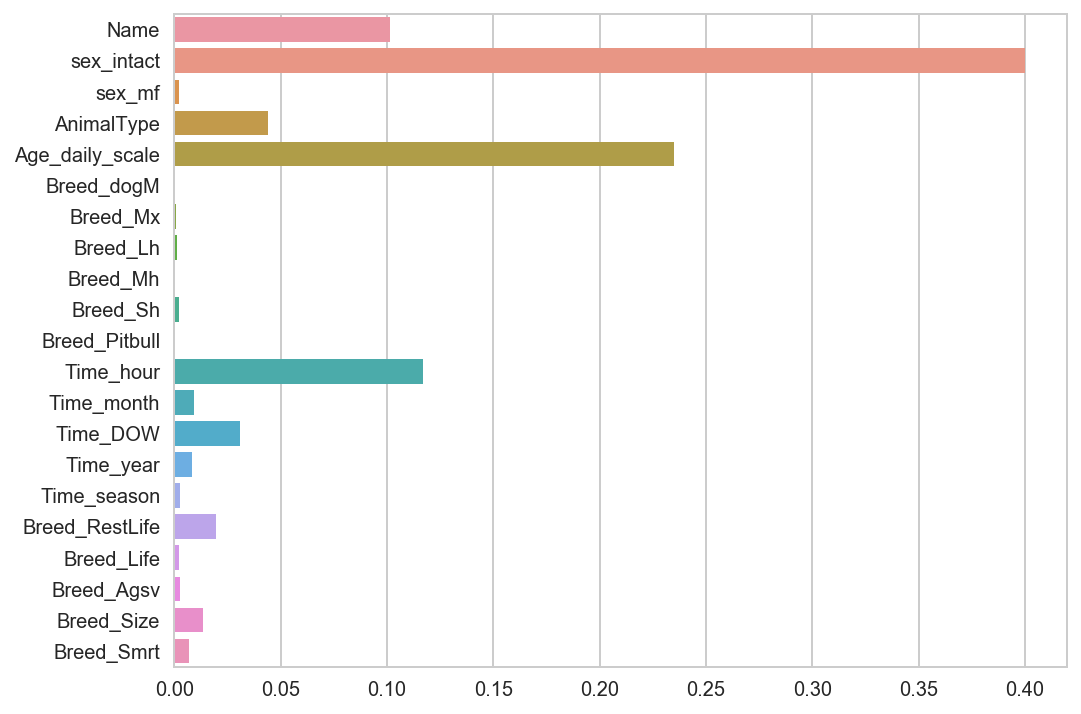

In [45]:
###### 피쳐 중요도
importance = tree_ls[7].feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:31], x=importance[:31])
# importance

### 랜덤포레스트 + cv

RFmodel creating.., 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19
model testing...
RandomForest Model1: CV Mean score: 0.654 --- acuraccy score : 0.656
RandomForest Model2: CV Mean score: 0.659 --- acuraccy score : 0.666
RandomForest Model3: CV Mean score: 0.668 --- acuraccy score : 0.680
RandomForest Model4: CV Mean score: 0.673 --- acuraccy score : 0.691
RandomForest Model5: CV Mean score: 0.678 --- acuraccy score : 0.708
RandomForest Model6: CV Mean score: 0.680 --- acuraccy score : 0.728
RandomForest Model7: CV Mean score: 0.684 --- acuraccy score : 0.754
RandomForest Model8: CV Mean score: 0.687 --- acuraccy score : 0.787
RandomForest Model9: CV Mean score: 0.688 --- acuraccy score : 0.825
RandomForest Model10: CV Mean score: 0.689 --- acuraccy score : 0.866
RandomForest Model11: CV Mean score: 0.691 --- acuraccy score : 0.905
RandomForest Model12: CV Mean score: 0.689 --- acuraccy score : 0.941
RandomForest Model13: CV Mean score: 0.688 --- acuraccy score : 0.966
RandomFores

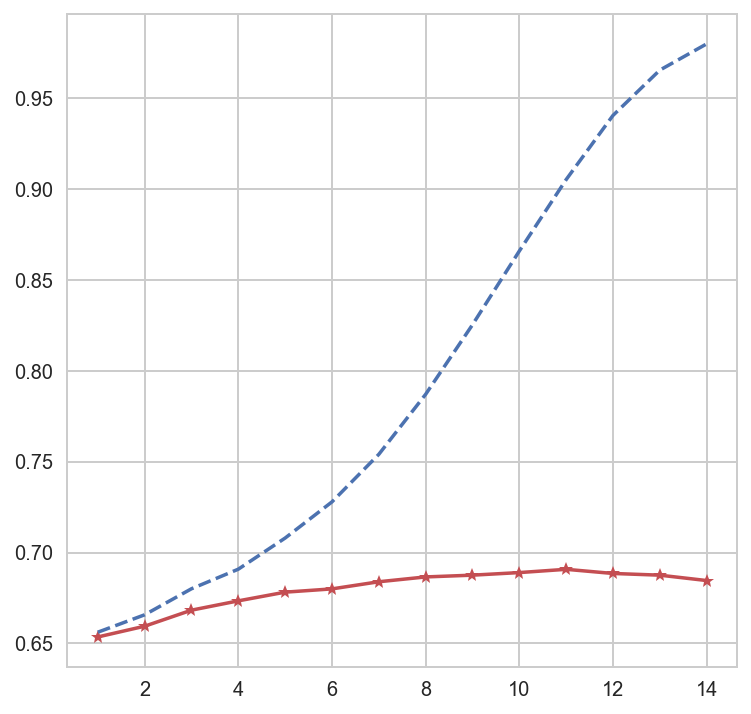

EXmodel creating.., 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
model testing...
ExtraTree Model1: CV Mean score: 0.615 --- acuraccy score : 0.616
ExtraTree Model2: CV Mean score: 0.631 --- acuraccy score : 0.636
ExtraTree Model3: CV Mean score: 0.638 --- acuraccy score : 0.642
ExtraTree Model4: CV Mean score: 0.644 --- acuraccy score : 0.653
ExtraTree Model5: CV Mean score: 0.650 --- acuraccy score : 0.664
ExtraTree Model6: CV Mean score: 0.655 --- acuraccy score : 0.685
ExtraTree Model7: CV Mean score: 0.659 --- acuraccy score : 0.695
ExtraTree Model8: CV Mean score: 0.662 --- acuraccy score : 0.721
ExtraTree Model9: CV Mean score: 0.667 --- acuraccy score : 0.741
ExtraTree Model10: CV Mean score: 0.671 --- acuraccy score : 0.779
ExtraTree Model11: CV Mean score: 0.672 --- acuraccy score : 0.812
ExtraTree Model12: CV Mean score: 0.673 --- acuraccy score : 0.843


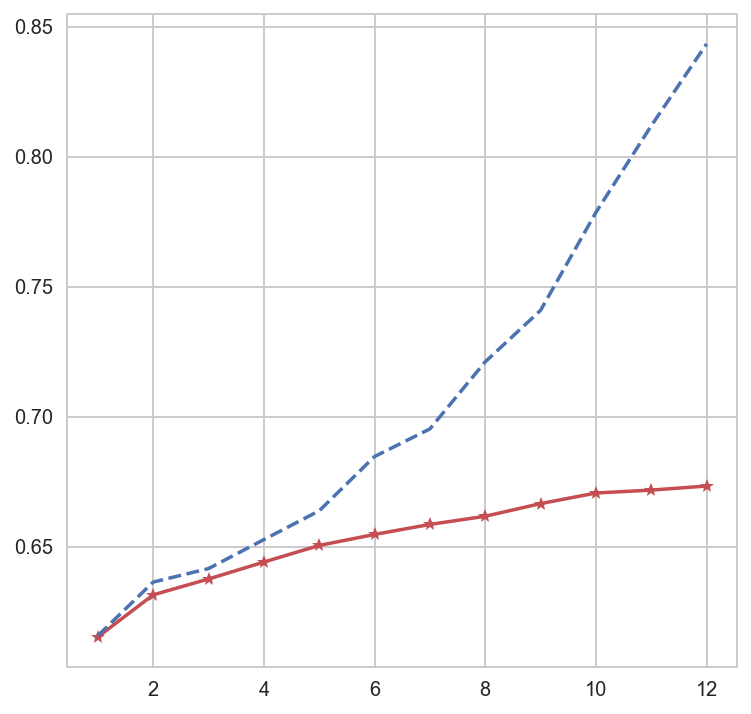

In [46]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import *
from sklearn.model_selection import cross_val_score, KFold
RF_ls = []
score_ls = []
accur_ls = []

# randomforest 모델 자동생성 반복문
print("RFmodel creating..",end="")
for i in range(6,20):
    RF = RandomForestClassifier(n_estimators=250, criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    RF_ls.append(RF)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(RF_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("RandomForest Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#----------------------------------------------------------------------
Ex_ls = []
score_ls = []
accur_ls = []
print("EXmodel creating..",end="")
for i in range(5,17):
    Ex = ExtraTreesClassifier(n_estimators=15, criterion='entropy', max_depth=i, random_state=0).fit(df_final,y)
    print(",",i,end="")
    Ex_ls.append(Ex)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(Ex_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("ExtraTree Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(6,6))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()
#고양이 cv최고기록 : 0.809 - n-esti:100// depth:20// (Breed 간략화) --> 0. Breed세분화
#강아지 cv최고기록 : 0.607 - n-esti:100// depth:14// (Breed 간략화) --> 0.610 n-esti:200/depth:15 (Breed세분화)
#종합 cv최고기록 : 0.690 - n-esti:250// depth:18// obj:'multi:softprob'

In [47]:
# plot_decision_regions(df_data,df_target, tree1, "Depth 1")
# plt.show()
RF = RandomForestClassifier(n_estimators = 250, criterion='entropy', max_depth=21, random_state=0).fit(df_final,y)

from sklearn.metrics import *
score = cross_val_score(RF, df_final, y,cv=10)
print("- CV_Score : {1:.3f}".format(i+1,np.mean(score)))
print("- Accuracy_Score : ", accuracy_score(y,RF.predict(df_final)))
print("- Confusion_Matrix \n",confusion_matrix(y, RF.predict(df_final)))
print(classification_report(y, RF.predict(df_final), target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,RF.predict(df_final)))

- CV_Score : 0.683
- Accuracy_Score :  0.9929290283961241
- Confusion_Matrix 
 [[10724     0     0    20    25]
 [    0   192     0     0     5]
 [    7     0  1525     4    19]
 [   40     0     0  4730    16]
 [   40     0     0    13  9369]]
                 precision    recall  f1-score   support

       Adoption       0.99      1.00      0.99     10769
           Died       1.00      0.97      0.99       197
     Euthanasia       1.00      0.98      0.99      1555
Return_to_owner       0.99      0.99      0.99      4786
       Transfer       0.99      0.99      0.99      9422

    avg / total       0.99      0.99      0.99     26729



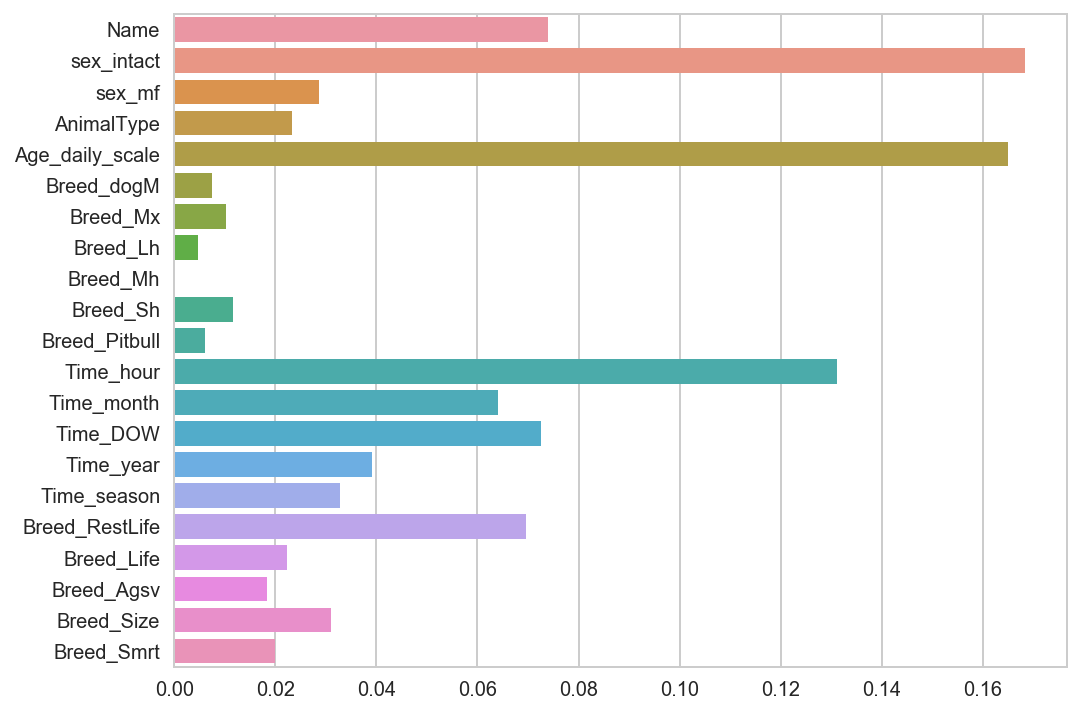

In [48]:
###### 피쳐 중요도
importance = RF_ls[9].feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:], x=importance[:])
# importance

### LightGBM 모델 + cv

model creating. max_depth==>, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15
model testing...


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model1: CV Mean score: 0.619 --- acuraccy score : 0.625


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model2: CV Mean score: 0.662 --- acuraccy score : 0.663


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model3: CV Mean score: 0.668 --- acuraccy score : 0.671


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model4: CV Mean score: 0.679 --- acuraccy score : 0.684


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model5: CV Mean score: 0.683 --- acuraccy score : 0.692


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model6: CV Mean score: 0.687 --- acuraccy score : 0.701


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model7: CV Mean score: 0.688 --- acuraccy score : 0.704


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model8: CV Mean score: 0.689 --- acuraccy score : 0.705


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model9: CV Mean score: 0.689 --- acuraccy score : 0.706


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model10: CV Mean score: 0.689 --- acuraccy score : 0.707


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model11: CV Mean score: 0.690 --- acuraccy score : 0.707


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model12: CV Mean score: 0.690 --- acuraccy score : 0.706


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model13: CV Mean score: 0.688 --- acuraccy score : 0.706


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model14: CV Mean score: 0.689 --- acuraccy score : 0.706


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model15: CV Mean score: 0.689 --- acuraccy score : 0.707


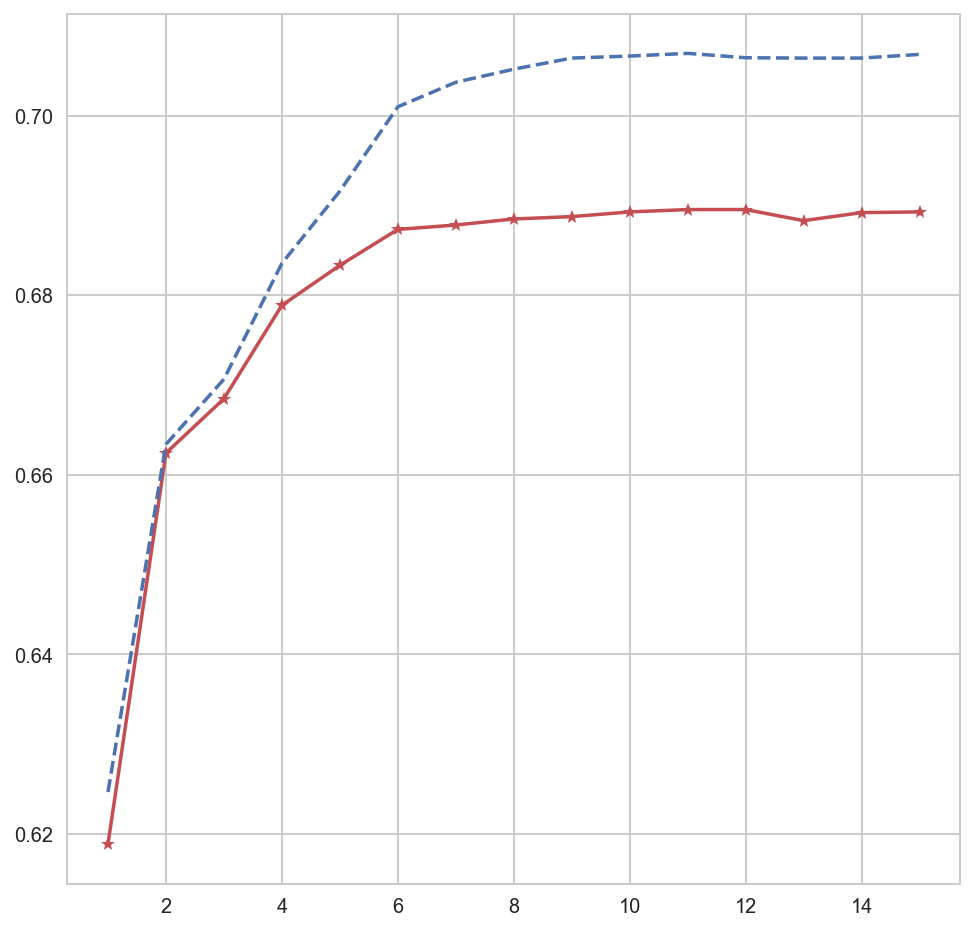

In [54]:
from sklearn.model_selection import cross_val_score, KFold
import lightgbm as lgb

model_ls = []
score_ls = []
accur_ls = []

# XGB 모델 자동생성 반복문
print("model creating. max_depth==>",end="") # max_depth
for i in range(1,16,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=50, objective="multi:softprob",
                             max_depth=i, random_state=0).fit(df_final,y) #max_depth=i
#     LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=250, objective="multi:softprob", nrounds=125, verbose=1, eta=0.2,
#                                colsample_bytree=0.8, eval_metric="mlogloss", subsample_for_bin=50000, learning_rate=0.2,
# subsample=0.75, max_depth=i, random_state=0).fit(df_final,y)
    
    print(",",i,end="")
    model_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(model_ls):
    scores = cross_val_score(model, df_final, y,cv=10)
    accuracy = accuracy_score(y,model.predict(df_final))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

#고양이 cv최고기록 : 0.821 - n-esti:250/ depth:12/ obj:'multi:softprob'/
#강아지 cv최고기록 : 0.618 - n-esti:200/ depth:-1/ obj:'multi:softprob'(종간략화)// 0.619 nesti:250/depth:3(종세분화)
#종합 cv최고기록 : 0.700 - n-esti:500/ depth:-1/ obj:'multi:softprob'/
# 직전최고기록 0.695 - 0.0 =  ___ nesti = 500/depth = 12,15,18
# 캐글 최고기록--> #0.696 - 0.794 = 98 ___ nesti = 350/depth = 11,17,18
                #0.695 - 0.770 = 72 ___ nesti = 250/depth = 16
                #0.694 - 0.741 = 45 ___ nesti = 150/depth = 12
                #0.694 - 0.729 = 35 ___ nesti = 120/depth = 13
                #0.694 - 0.723 = 29 ___ nesti = 100/depth = 15 #예제그래프로 활용가능할듯 
                #0.693 - 0.716 = 23 ___ nesti = 80/depth = 15
                #0.692 - 0.714 = 22 ___ nesti = 70/depth = 11
                #0.690 - 0.706 = 16 ___ nesti = 50/depth = 16

In [55]:
import lightgbm as lgb 

from sklearn.metrics import *

LGB_model = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=150, objective="multi:softprob",
                                max_depth=-1, random_state=0).fit(df_final,y)

scores = cross_val_score(LGB_model, df_final, y,cv=10)
y_pred = LGB_model.predict(df_final)
accuracy = accuracy_score(y,y_pred)
print(("LGB Model{0:d}: Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교

print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
print(classification_report(y, y_pred, target_names=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"]))
# print("- Log-loss :", log_loss(y,y_pred))


/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this wi

LGB Model15: Mean score: 0.694 --- acuraccy score : 0.740
- Confusion_Matrix 
 [[9239    0   18  909  603]
 [  10   86    5    5   91]
 [ 155    2  587  291  520]
 [1590    0   46 2711  439]
 [1443    0   89  742 7148]]
                 precision    recall  f1-score   support

       Adoption       0.74      0.86      0.80     10769
           Died       0.98      0.44      0.60       197
     Euthanasia       0.79      0.38      0.51      1555
Return_to_owner       0.58      0.57      0.57      4786
       Transfer       0.81      0.76      0.78      9422

    avg / total       0.74      0.74      0.73     26729



/usr/local/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


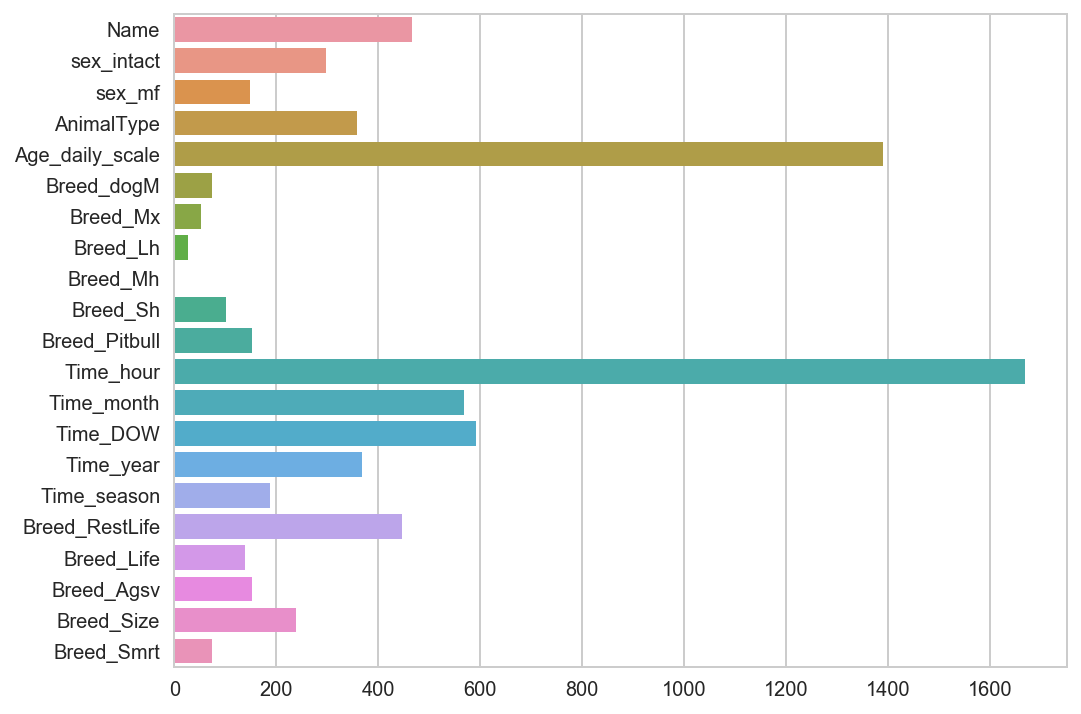

In [56]:
## 피쳐 중요도
importance = model_ls[10].feature_importances_
plt.figure(figsize=(8,6))
sns.barplot(y=df_final.columns[:31], x=importance[:31])
# importance

### 신경망 모델 Keras

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_final, y, test_size=0.2, random_state=0)

import tensorflow as tf
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train, 5)
Y_test = np_utils.to_categorical(y_test, 5)

print("입력갯수 :",len(X_train.columns))
# Y_test

In [ ]:
# from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras import regularizers

np.random.seed(0)

model0 = Sequential()
model0.add(Dense(15, input_dim=len(X_train.columns), activation="sigmoid")) # 레이어 1
# model0.add(Dense(35, activation="sigmoid")) # 레이어 2
model0.add(Dense(5, activation="softmax")) # 레이어 3 --> dim 안서줘도 된다. 이전에 이미 했기때문에
model0.compile(optimizer=SGD(lr=3.2), loss='mean_squared_error', metrics=["accuracy"])

#고양이 최고기록 : acc:0.85, valacc:0.7532 l1- 50 sigmoid, l2- 25 sigmoid, l3- 5 sigmiod, epoch:3000
#강아지 최고기록 : 0.4732 
#종합 최고기록 : 0. 

In [ ]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import os
os.environ["PATH"] += os.pathsep + 'C:/Users/creal/graphviz-2.38/release/bin'

SVG(model_to_dot(model0, show_shapes=True).create(prog='dot', format='svg'))

In [ ]:
model0.summary()

In [ ]:
l1 = model0.layers[0]
l2 = model0.layers[1]

In [ ]:
l1.name, type(l1), l1.output_shape, l1.activation.__name__, l1.count_params()

In [ ]:
l2.name, type(l2), l2.output_shape, l2.activation.__name__, l2.count_params()

In [ ]:
%%time

# fit 메서드로 트레이닝 실시 (hist로 반환하면 그래프로 뿌리기 용이하다.)
hist = model0.fit(X_train, Y_train, 
                 epochs=608, 
                 validation_data=(X_test, Y_test), 
                 verbose=2)

In [ ]:
plt.plot(hist.history['loss'])
plt.show()

In [ ]:
#자료가 좋으면 테스트가 더 높게 나올수도 있다.
plt.plot(hist.history['acc'], 'b-', label="training")
plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import *
y_pred = hist.model.predict_classes(df_final,verbose=0)
# print(y_pred)
print("- Accuracy_Score : ", accuracy_score(y, y_pred))
print("- Confusion_Matrix \n",confusion_matrix(y, y_pred))
# hist.model.predict_classes

### 신경망 Target 생성

In [ ]:
y_categ= np_utils.to_categorical(y, 5)
hist = model0.fit(df_final,y_categ,
                 epochs=100,  
                 verbose=2)

In [ ]:
#자료가 좋으면 테스트가 더 높게 나올수도 있다.
plt.plot(hist.history['acc'], 'b-', label="training")
# plt.plot(hist.history['val_acc'], 'r:', label="test")
plt.legend()
plt.show()

In [ ]:
keras_pred= hist.model.predict(df_test,verbose=0)
keras_pred

In [ ]:
Final_keras = pd.DataFrame(keras_pred, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
Final_keras["ID"] = np.arange(1,len(Final_keras["Adoption"])+1)
Final_submission = Final_keras[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
Final_submission.tail(20)

## 7. To improve performace
- AnimalType 별로 나눠서 EDA와 모델 만들어 비교할 예정
- 최적화
- 비대칭 데이터 해결

In [ ]:
sorted_df = train.groupby(["OutcomeType","AnimalType"]).size().reset_index(name="count")
fig = plt.figure(figsize=(12,8))
ax = sns.barplot(data = sorted_df, x="count", y="OutcomeType", hue="AnimalType")
ax.set_xlabel('Counts')
ax.set_ylabel('OutcomeType')
print("동물의 처리결과별 - 종 통계")
# 0은 1년생 미만의 동물개체
# -1은 나이정보가 없었던 동물

# Test DATA 예측모델에 적용 --> Target 값 생성

- 사전작업 : test데이터의 신규 동물종에 대한 스펙 Breed_dev에 반영

> ### 1. 전체데이터
>
> ### 2. AnimalType 별 분할데이터로 모델 최적화
        - (강아지, 고양이 모델 따로 생성후 결합)
        - 각 모델 생성 및 예측 --> 결과값 결합

In [ ]:
# 종류 missing 데이터 찾음
#test 데이터- 강아지 종류 missing!
# tmp_test[(tmp_test["ID"]==1672)|(tmp_test["ID"]==3923)|(tmp_test["ID"]==4457)|(tmp_test["ID"]==5471)|(tmp_test["ID"]==6036)|(tmp_test["ID"]==6619)|(tmp_test["ID"]==10623)].Breed_extra.unique()
#test 데이터- 고양이 종류 missing!
# tmp_test[(tmp_test["ID"]==675)|(tmp_test["ID"]==1185)|(tmp_test["ID"]==5556)|(tmp_test["ID"]==5875)|(tmp_test["ID"]==8173)|(tmp_test["ID"]==9215)].Breed_extra.unique()

In [ ]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")

test_if = test.copy()

# 전체데이터 (한번만 작동하면 됨)
# tmp_test = preprocessShelter(test_if)
# df_tcolors2, df_tbreeds2 = preprocessColorBreed(tmp_test,Breed_dev)

df_Ctgt = allCategorizer(tmp_test,cols2)

df_test = pd.concat([df_Ctgt,df_tbreeds2],axis=1) #분석제외 <== df_tcolors2,

df_test = df_test[['Name', 'sex_intact', #'sex_unknown',
                     'sex_mf', 'AnimalType', 'Age_daily_scale',
                     #'Age_code',
                     'Breed_dogM', 'Breed_Mx',
                     'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                     'Breed_Pitbull',
                     'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                     'Time_season', #'Holidays', 
                     'Breed_RestLife', 'Breed_Life', 'Breed_Agsv', 'Breed_Size',  #'Breed_Acti',
                     'Breed_Smrt', #'Breed_Frdy'
                    ]]


In [ ]:
#전체데이터(무분할)
submit_proba0 = model_ls[0].predict_proba(df_test)
submit_proba0

In [ ]:
Final_data = pd.DataFrame(submit_proba0, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
Final_data["ID"] = np.arange(1,len(Final_data["Adoption"])+1)
Final_submission = Final_data[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
Final_submission.tail(20)

## Kaggle 제출 결과 Score

## 동물 종에 따른 데이터 분할

In [ ]:
# 나이정보가 없는 경우는 -1로 처리한뒤 차후에 Mode값에 산입
test["SexuponOutcome"] = test["SexuponOutcome"].fillna("Unknown")
test["AgeuponOutcome"] = test["AgeuponOutcome"].fillna("-1 nodata")

#DF 설정 (고양이 or 개)
test_Cat = test[test["AnimalType"]=="Cat"].copy()
test_Dog = test[test["AnimalType"]=="Dog"].copy()


# 고양이 종 분류 데이터 (한번작동 필요)
# tmp_Cat = preprocessShelter(test_Cat)
# df_colors_cat, df_breeds_cat = preprocessColorBreed(tmp_Cat,Breed_dev)

# 강아지 종 분류 데이터 (한번작동 필요)
# tmp_Dog = preprocessShelter(test_Dog)
# df_colors_dog, df_breeds_dog = preprocessColorBreed(tmp_Dog,Breed_dev)


#카테고라이징
df_Ctg_Cat = allCategorizer(tmp_Cat,cols2)
df_Ctg_Dog = allCategorizer(tmp_Dog,cols2)

df_test_Cat = pd.concat([df_Ctg_Cat,df_breeds_cat],axis=1)# df_tcolors2,
df_test_Dog = pd.concat([df_Ctg_Dog,df_breeds_dog],axis=1)# df_tcolors2,

# 개,고양이 피쳐 On,Off------------------------------
#냥이
df_test_Cat = df_test_Cat[['Name', 'sex_intact', #'sex_unknown',
                         'sex_mf', 'AnimalType', 'Age_daily_scale',
                         #'Age_code',
                         'Breed_dogM', 'Breed_Mx',
                         'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                         #'Breed_Pitbull',
                         'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                         'Time_season', #'Holidays', 
                         'Breed_RestLife', 'Breed_Life', 'Breed_Size', #'Breed_Agsv', #'Breed_Acti',
                         'Breed_Smrt', #'Breed_Frdy'
                        ]]
#개
df_test_Dog = df_test_Dog[['Name', 'sex_intact', #'sex_unknown',
                         'sex_mf', 'AnimalType', 'Age_daily_scale',
                         #'Age_code',
                         'Breed_dogM', 'Breed_Mx',
                         'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                         'Breed_Pitbull',
                         'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                         'Time_season', #'Holidays', 
                         'Breed_RestLife', 'Breed_Life', 'Breed_Agsv', 'Breed_Size',  #'Breed_Acti',
                         'Breed_Smrt', #'Breed_Frdy'
                        ]]


### 강아지 LightGBM최적화

In [ ]:
#강아지용
import lightgbm as lgb

#강아지용 training set
df_dfinal = df_final[df_final["AnimalType"]==1].copy()

from sklearn.preprocessing import LabelEncoder
dog_tr = train[train["AnimalType"]=="Dog"].copy()
dle = LabelEncoder()
dy = dog_tr["OutcomeType"]
dle.fit(dy)
dy= le.transform(dy)

dog_ls = []
score_ls = []
accur_ls = []

# LigntGBM 모델 자동생성 반복문
print("model creating. max_depth==>",end="")
for i in range(3,21,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=100, objective="multi:softprob",
                             max_depth=i, random_state=0).fit(df_dfinal,dy)    
    print(",",i,end="")
    dog_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(dog_ls):
    scores = cross_val_score(model, df_dfinal, dy,cv=10)
    accuracy = accuracy_score(dy,model.predict(df_dfinal))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 결과 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

#고양이 cv최고기록 : 0.821 - n-esti:250/ depth:12/ obj:'multi:softprob'/
#강아지 cv최고기록 : 0.618 - n-esti:200/ depth:-1/ obj:'multi:softprob'(종간략화)// 0.619 nesti:250/depth:3(종세분화)

# 진행된 최근 점수 : 0.615 - 0.676 = ___ nesti = 200/depth = 5,(19)
# 결합모형 캐글최고점수 : 0.617 - 0.676 = ___ nesti = 150/depth = (6),18

In [ ]:
## 피쳐 중요도
plt.figure(figsize=(8,8))
plt.subplot(211)
importance = dog_ls[9].feature_importances_
sns.barplot(y=df_dfinal.columns[:31], x=importance[:31])
plt.subplot(212)
importance = dog_ls[12].feature_importances_
# plt.figure(figsize=(8,6))
sns.barplot(y=df_dfinal.columns[:31], x=importance[:31])


### 고양이 LightGBM최적화

In [ ]:
#고양이용
import lightgbm as lgb

#고양이용 training set
df_cfinal = df_final[df_final["AnimalType"]==0].copy()
df_cfinal = df_cfinal[['Name', 'sex_intact', #'sex_unknown',
                         'sex_mf', 'AnimalType', 'Age_daily_scale',
                         #'Age_code',
                         'Breed_dogM', 'Breed_Mx',
                         'Breed_Lh', 'Breed_Mh', 'Breed_Sh', #'Breed_Do', 
                         #'Breed_Pitbull',
                         'Time_hour', 'Time_month', 'Time_DOW', 'Time_year', #'Time_weekend',
                         'Time_season', #'Holidays', 
                         'Breed_RestLife', 'Breed_Life', 'Breed_Size', #'Breed_Agsv', #'Breed_Acti',
                         'Breed_Smrt', #'Breed_Frdy'
                        ]]

from sklearn.preprocessing import LabelEncoder
cat_tr = train[train["AnimalType"]=="Cat"].copy()
cle = LabelEncoder()
cy = cat_tr["OutcomeType"]
cle.fit(cy)
cy= le.transform(cy)

cat_ls = []
score_ls = []
accur_ls = []

# LigntGBM 모델 자동생성 반복문
print("model creating. max_depth==>",end="")
for i in range(3,21,1):
    LGB = lgb.LGBMClassifier(boosting_type="gbdt", n_estimators=50, objective="multi:softprob",
                             max_depth=i, random_state=0).fit(df_cfinal,cy)    
    print(",",i,end="")
    cat_ls.append(LGB)

# 모델 CV돌리기
print("\nmodel testing...")
for i, model in enumerate(cat_ls):
    scores = cross_val_score(model, df_cfinal, cy,cv=10)
    accuracy = accuracy_score(cy,model.predict(df_cfinal))
    print(("LGB Model{0:d}: CV Mean score: {1:.3f}").format(i+1,np.mean(scores)), end="")
    print((" --- acuraccy score : {0:.3f}").format(accuracy)) # Kfold 안했을때 비교
    score_ls.append(np.mean(scores))
    accur_ls.append(accuracy)
    
# 결과 플롯팅 
plt.figure(figsize=(8,8))
plt.plot(range(1,len(score_ls)+1),list(score_ls),'-*r')
plt.plot(range(1,len(accur_ls)+1),list(accur_ls),'--b')
plt.show()

#고양이 cv최고기록 : 0.821 - n-esti:250/ depth:12/ obj:'multi:softprob'/
#강아지 cv최고기록 : 0.618 - n-esti:200/ depth:-1/ obj:'multi:softprob'(종간략화)// 0.619 nesti:250/depth:3(종세분화)

# 진행된 최근 점수 : 0.817 - 0.913 = 72 ___ nesti = 250/depth = 11,(14),18
# 결합모형 캐글최고점수 : 0.817 - 0.899 = 72 ___ nesti = 200/depth = 11, (14), 18

In [ ]:
## 피쳐 중요도

plt.figure(figsize=(8,8))
plt.subplot(211)
importance = cat_ls[5].feature_importances_
sns.barplot(y=df_cfinal.columns[:31], x=importance[:31])
plt.subplot(212)
importance = cat_ls[11].feature_importances_
sns.barplot(y=df_cfinal.columns[:31], x=importance[:31])

### 종별 Target값 산출

In [ ]:
### 고양이
submit_proba_c = cat_ls[11].predict_proba(df_test_Cat)
submit_proba_c

In [ ]:
result_cat = pd.DataFrame(submit_proba_c, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
result_cat.tail()

In [ ]:
###### 강아지
submit_proba_d = dog_ls[9].predict_proba(df_test_Dog)
submit_proba_d

In [ ]:
result_dog = pd.DataFrame(submit_proba_d, columns=["Adoption","Died","Euthanasia","Return_to_owner","Transfer"])
result_dog.tail()

In [ ]:
#merging - 고양이,강아지 합치기

cat_i,dog_i = 0,0
sub_ls = []
for idx in range(0,len(test["ID"])):
#     print(idx,end="")
    if test.AnimalType[idx]=="Cat":
        sub_ls.append(dict(result_cat.iloc[cat_i]))
        cat_i += 1
    else :
        sub_ls.append(dict(result_dog.iloc[dog_i]))
        dog_i += 1
Final_submission = pd.DataFrame(sub_ls)
Final_submission["ID"] = np.arange(1,len(Final_submission["Adoption"])+1)
Final_submission = Final_submission[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
Final_submission.head(10)

In [ ]:
# cross change merging - 특정종은 전체데이터모델에서, 다른종은 최적화모델에서
# 고양이(특화모델),강아지(전체모델) 합치기

cat_i,dog_i = 0,0
temp_cat = Final_data[test["AnimalType"]=="Cat"].copy()
sub_ls = []
for idx in range(0,len(test["ID"])):
#     print(idx,end="")
    if test.AnimalType[idx]=="Cat":
        sub_ls.append(dict(temp_cat.iloc[cat_i]))
        cat_i += 1
    else :
        sub_ls.append(dict(result_dog.iloc[dog_i]))
        dog_i += 1
Final_submission = pd.DataFrame(sub_ls)
Final_submission["ID"] = np.arange(1,len(Final_submission["Adoption"])+1)
Final_submission = Final_submission[["ID","Adoption","Died","Euthanasia","Return_to_owner","Transfer"]]
Final_submission.head(10)

## 분석된 Final Proba - target값 경향분석

In [ ]:
# Final_submission[Final_submission["Adoption"]>0.948].count()
# sum([int(i) for i in y[Final_submission["Adoption"]>0.948] == 0])
# Final_submission[Final_submission["Died"]>0.34].count()
# sum([int(i) for i in y[Final_submission["Died"]>0.34] == 1])
# Final_submission[Final_submission["Euthanasia"]>0.69].count()
# sum([int(i) for i in y[Final_submission["Euthanasia"]>0.69] == 2])
# Final_submission[Final_submission["Return_to_owner"]>0.4].count()
# sum([int(i) for i in y[Final_submission["Return_to_owner"]>0.4] == 3])
# Final_submission[Final_submission["Transfer"]>0.937].count()
# sum([int(i) for i in y[Final_submission["Transfer"]>0.937] == 4])

In [ ]:
# 유의수준 1%미만으로 보고 Proba극한으로 변형 (이건 하지 않기로...)
def changeProba(df_raw,col,val):
    df = df_raw.copy()
    idxs = df[col] > val
    df.Adoption[idxs] = int(col=='Adoption')
    df.Died[idxs] = int(col=='Died')
    df.Euthanasia[idxs] = int(col=='Euthanasia')
    df.Return_to_owner[idxs] = int(col=='Return_to_owner')
    df.Transfer[idxs] = int(col=='Transfer')
    return df

# adoption 0.8 == 171/3671 오차율
# adoption 0.85== 79/2732 오차율
# adoption 0.9 == 44/1847 오차율
# adoption 0.92== 18/1164 오차율 
# adoption 0.93== 10/956 오차율 1.04%
# adoption 0.94== 8/840 오차율 0.95%
# adoption 0.945== 5/526 오차율 0.95%
# adoption 0.948== 2/246 오차율 0.81%
# adoption 0.95== 0/4 오차율 0%
# Final_submission = changeProba(Final_submission,"Adoption",0.93)

# Died 0.3 == 3/43 오차율
# Died 0.33== 2/40 오차율
# Died 0.34== 0/38 오차율 0%
# Final_submission = changeProba(Final_submission,"Died",0.34)

# Euthan 0.5 == 71/339 오차율
# Euthan 0.6 == 30/199 오차율
# Euthan 0.65== 13/125 오차율
# Euthan 0.7 == 1/54 오차율 1.85%
# Euthan 0.71== 1/42 오차율
# Euthan 0.72== 1/33 오차율
# Euthan 0.73 == 0/23 오차율 0%
# Final_submission = changeProba(Final_submission,"Euthanasia",0.75)

# Return 0.65 == 11/109 오차율
# Return 0.67 == 3/70 오차율
# Return 0.7 == 1/31 오차율 3.2%
# Return 0.72== 1/13 오차율
# Return 0.73== 0/6 오차율 0%
Final_submission = changeProba(Final_submission,"Return_to_owner",0.73)

# Transfer 0.75 == 206/4196 오차율 5%
# Transfer 0.8 == 142/3561 오차율 
# Transfer 0.85 == 100/2985 오차율 3.3%
# Transfer 0.9 == 66/2474 오차율 2.66%
# Transfer 0.92 == 41/1901 오차율 2.16%
# Transfer 0.93 == 25/1301 오차율 1.92%
# Transfer 0.935== 16/1065 오차율 1.5%
# Transfer 0.937== 10/851 오차율 1.17%
# Transfer 0.938== 7/666 오차율 1.05%
# Transfer 0.94 == 4/322 오차율 1.24%
# Transfer 0.942== 3/142 오차율
Final_submission = changeProba(Final_submission,"Transfer",0.90)

In [ ]:
Final_submission[Final_submission["Return_to_owner"]==1]

# Submission CSV파일 생성

In [ ]:
Final_submission.to_csv('NeuralNetwork5_KERAS(sigm15_softmax5_lr3_2_epoch200).csv', index=False) # Merged_cross_05_Cat(ALLd16,ne250)AndDog(d12,ne100)

### 최종 Kaggle 순위

In [ ]:
# 캐글순위 최종 상위 16.7%
267/1599
